# Introduction

### Project initialization and setup

Importing all of the libraries that will be used. In the project.

In [48]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture


Connecting the DB to SQL

In [49]:
DB_PATH = "viewer_interactions.db"

try:
    conn = sqlite3.connect(DB_PATH)
    print("Connected successfully!")
except sqlite3.Error as e:
    print("Connection failed:", e)

Connected successfully!


In [50]:
# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

Listing all the tables

In [51]:
tables_query = """
               SELECT name
               FROM sqlite_master
               WHERE type='table'
               ORDER BY name; \
               """

tables_df = pd.read_sql_query(tables_query, conn)
print("Tables in the database:")
display(tables_df)

Tables in the database:


,name
0,data_dictionary
1,movie_statistics
2,movies
3,user_statistics
4,viewer_ratings


Creating a dictionary of type table_name -> DataFrame

In [52]:
table_names = tables_df["name"].tolist()

schemas = {}

for table in table_names:
    pragma_query = f"PRAGMA table_info({table});"
    schema_df = pd.read_sql_query(pragma_query, conn)
    schemas[table] = schema_df
    print(f"\nSchema for table '{table}':")
    display(schema_df)


Schema for table 'data_dictionary':


,cid,name,type,notnull,dflt_value,pk
0,0,table_name,TEXT,0,None,0
1,1,field_name,TEXT,0,None,0
2,2,data_type,TEXT,0,None,0
3,3,description,TEXT,0,None,0



Schema for table 'movie_statistics':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,total_ratings,REAL,0,None,0
2,2,avg_rating,REAL,0,None,0
3,3,std_rating,REAL,0,None,0
4,4,min_rating,REAL,0,None,0
5,5,max_rating,REAL,0,None,0
6,6,unique_users,REAL,0,None,0
7,7,first_rating_date,TEXT,0,None,0
8,8,last_rating_date,TEXT,0,None,0
9,9,year_of_release,REAL,0,None,0



Schema for table 'movies':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,year_of_release,REAL,0,None,0
2,2,title,TEXT,0,None,0



Schema for table 'user_statistics':


,cid,name,type,notnull,dflt_value,pk
0,0,customer_id,INTEGER,0,None,0
1,1,total_ratings,REAL,0,None,0
2,2,avg_rating,REAL,0,None,0
3,3,std_rating,REAL,0,None,0
4,4,min_rating,REAL,0,None,0
5,5,max_rating,REAL,0,None,0
6,6,unique_movies,REAL,0,None,0
7,7,first_rating_date,TEXT,0,None,0
8,8,last_rating_date,TEXT,0,None,0
9,9,activity_days,REAL,0,None,0



Schema for table 'viewer_ratings':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,customer_id,INTEGER,0,None,0
2,2,rating,REAL,0,None,0
3,3,date,TEXT,0,None,0
4,4,anomalous_date,INTEGER,0,None,0


DF_MAP is the lookup table that links each global DataFrame name (for instance movies_stats) to its actual entry inside the dfs dictionary. It is filled by add_new_df function whenever a new dataframe is registered.


In [53]:
# creating a dictionary to map dataframes
DF_MAP = {}

### Methods

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Add new data frame function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Registers a dataframe under a global variable name while keeping a main dfs dictionary as the source.

**Inputs:**<br>
Takes global_name (new global variable name), dfs_key (dictionary key in dfs), and optional dataframe (only used if dfs_key is not already present) as inputs.

**Behaviour:**<br>
If dfs_key already exists in dfs, it simply maps that existing dataframe to the requested global name and records the mapping in DF_MAP. Otherwise, it raises an error when no dataframe is provided, or it stores the new dataframe in both dfs and the global namespace, updating DF_MAP.

**Output:**<br>
Doesn't return anything, prints whether an existing or new dataframe was mapped.


In [54]:
def add_new_df(global_name: str, dfs_key: str, dataframe=None):

    # if dataframe already exists in dfs then ignore "dataframe" input
    if dfs_key in dfs:
        globals()[global_name] = dfs[dfs_key]
        DF_MAP[global_name] = dfs_key
        print(f"Mapped existing dfs['{dfs_key}'] to global '{global_name}'")
        return

    # new dataframe
    if dataframe is None:
        raise ValueError(
            f"dfs_key '{dfs_key}' does not exist in dfs and no dataframe was provided."
        )

    dfs[dfs_key] = dataframe
    globals()[global_name] = dataframe
    DF_MAP[global_name] = dfs_key

    print(f"Added NEW df: global '{global_name}' → dfs['{dfs_key}']")

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Sync data frame function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Refreshing the global dataframe variables so they always match the newest versions stored inside the dfs dictionary.

**Inputs:**<br>
One or more dataframe objects that currently exist as global variables.

**Behavior:**<br>
For each passed dataframe, it looks up the corresponding DF_MAP entry and replaces the global variable with the latest version from dfs. If a dataframe isn’t found in DF_MAP, it raises an error.

**Output:**<br>
Silently updates globals or raises on unknown inputs.

In [55]:
def sync_dataframe(*dfs_to_refresh):
    globals_dict = globals()

    for df_obj in dfs_to_refresh:
        updated = False

        for global_name, dfs_key in DF_MAP.items():
            if df_obj is globals_dict[global_name]:
                globals_dict[global_name] = dfs[dfs_key]
                updated = True
                break

        if not updated:
            raise ValueError("Unknown dataframe passed!")

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Search by parameter function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Searches for required parameters in dataframes

**Inputs:**<br>
table_name (dataframe key in dfs), key (column name), and value (target value or None to locate nulls).

**Behavior:**<br>
Retrieves the dataframe from dfs, then returns rows where the column matches value. If value is None, it returns rows with nulls in that column.

**Output:** <br>
Returns a filtered dataframe matching the search condition.

In [56]:
def search_by_parameter(table_name, key, value):
    df = dfs[table_name]

    if value is None:
        return df[df[key].isna()]

    return df[df[key] == value]

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Manual std values calculation function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Computes the standard deviation, see the used formula in README

**Inputs:**<br>
Values iterable convertible to a NumPy array.

**Behavior:**<br>
 Converts to float array, returns 0.0 for length is lees or equal to 1, otherwise calculates mean and square-root of mean squared deviation.

**Output:**<br>
A float representing the standard deviation

In [57]:
# make sure no nulls are included in the calculation!

def manual_std(values):
    arr = np.array(values, dtype=float)

    n = len(arr)

    if n <= 1:
        return 0.0

    mean = arr.mean()
    return np.sqrt(((arr - mean) ** 2).mean())

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Safe string to datetime convertion function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Parsing a "YYYY-MM-DD" formatted string into a datetime.

**Inputs:**<br>
String in a "YYYY-MM-DD" format.

**Behavior:**<br>
Converting string to a datetime.strptime type or None for null/NaN

**Output:**<br>
Returns a datetime object or None when parsing fails or input is missing.

In [58]:
def covert_string_to_date(date_str):
    if date_str is None or pd.isna(date_str):
        return None
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except:
        return None

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Elbow method</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Evaluates KMeans inertia across a range of cluster counts to find an elbow point.

**Inputs:**<br>
Feature matrix X, cluster bounds k_min/k_max, random_state, and a "plot" bool to indicate necessity of plotting.

**Behavior:**<br>
Fits KMeans for each k, collects inertia values into a dataframe, and plots inertia vs k.

**Output:**<br>
A dataframe with columns k and inertia, optionally draws a plot for visual elbow inspection

In [59]:
def elbow_method(X, k_min=1, k_max=10, random_state=42, plot=True):
    results = []

    for k in range(k_min, k_max + 1):
        kmeans = KMeans(
            n_clusters=k,
            random_state=random_state,
            n_init=10
        )
        kmeans.fit(X)
        results.append({"k": k, "inertia": kmeans.inertia_})

    elbow_df = pd.DataFrame(results)

    if plot:
        plt.figure()
        plt.plot(elbow_df["k"], elbow_df["inertia"], marker="o")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow method")
        plt.xticks(elbow_df["k"])
        plt.show()

    return elbow_df

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Silhouette score computation function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculates silhouette score for clustering results

**Inputs:**<br>
Feature matrix X, cluster label array labels, optional sample_size, random_state, and distance metric.

**Behavior:**<br>
Validates matching lengths, then computes silhouette_score with the chosen metric.

**Output:**<br>
Returns a single float silhouette score summarizing cluster separation and cohesion.

In [60]:
def compute_silhouette_score(X, labels, sample_size=None, random_state=42, metric="euclidean"):
    X = np.asarray(X)
    labels = np.asarray(labels)

    if X.shape[0] != labels.shape[0]:
        raise ValueError(f"X has {X.shape[0]} rows, but labels has {labels.shape[0]} elements")

    if sample_size is not None and sample_size < len(X):
        rng = np.random.RandomState(random_state)
        idx = rng.choice(len(X), size=sample_size, replace=False)
        X_used = X[idx]
        labels_used = labels[idx]
    else:
        X_used = X
        labels_used = labels

    score = silhouette_score(X_used, labels_used, metric=metric)
    return score

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Movie cluster inspection function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Lists movies belonging to a specific cluster.

**Inputs:**<br>
movies_df containing movie_id and cluster_id, merged_df with movie_id and title, and a target cluster_id to inspect.

**Behavior:**<br>
Looking for rows matching the cluster, displays descriptive stats, then merges titles onto those rows for readability.

**Output:**<br>
Returns a dataframe of cluster members with movie titles, along with a displayed statistical summary

In [61]:
def inspect_movie_cluster(movies_df, merged_df, cluster_id):

    cluster = movies_df[movies_df["cluster_id"] == cluster_id]

    display(cluster.describe())

    detailed = cluster.merge(
        merged_df[["movie_id", "title"]].drop_duplicates(),
        on="movie_id",
        how="left"
    )

    return detailed

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Cluster visualization function</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Visualizes clusters in two dimensions using PCA

**Inputs:**<br>
Scaled feature matrix X_scaled, cluster_labels, and optional cap on points per cluster to reduce clutter (only for visual purposes).

**Behavior:**<br>
Projects data to two principal components, builds a plotting dataframe, samples large clusters for readability, and scatters each cluster with size/edge styling based on cluster size. Adds variance percentages to axes, legend counts, and grid.

**Output:**<br>
Displays a PCA scatter plot showing cluster separation; no return value beyond visualization

In [62]:
def plot_clusters_pca_2d(X_scaled, cluster_labels, max_points_per_cluster=1000):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    df_plot = pd.DataFrame({
        "pc1": X_pca[:, 0],
        "pc2": X_pca[:, 1],
        "cluster": cluster_labels
    })

    unique_clusters = sorted(df_plot["cluster"].unique())

    plt.figure(figsize=(9, 7))

    for cid in unique_clusters:
        cluster_points = df_plot[df_plot["cluster"] == cid]

        if len(cluster_points) > max_points_per_cluster:
            cluster_points = cluster_points.sample(
                max_points_per_cluster,
                random_state=42
            )

        if len(df_plot[df_plot["cluster"] == cid]) <= 50:
            s = 20
            edgecolor = "black"
            linewidth = 0.7
        else:
            s = 20
            edgecolor = "none"
            linewidth = 0.0

        plt.scatter(
            cluster_points["pc1"],
            cluster_points["pc2"],
            s=s,
            alpha=0.6,
            label=f"Cluster {cid} (n={len(df_plot[df_plot['cluster'] == cid])})",
            edgecolors=edgecolor,
            linewidths=linewidth
        )

    var1, var2 = pca.explained_variance_ratio_
    plt.xlabel(f"PC1 ({var1:.1%} variance)")
    plt.ylabel(f"PC2 ({var2:.1%} variance)")
    plt.title("K-means movie clusters (PCA 2D)")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Spicialized cluster visualization function for DBSCAN</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Visualizes DBSCAN clustering results in two dimensions using PCA, explicitly highlighting both clustered points and noise.

**Inputs:**<br>
Scaled feature matrix X_scaled and DBSCAN labels (cluster IDs plus -1 for noise), with an optional cap max_points_per_cluster to subsample large clusters for clearer visualization, and an optional title for the plot.

**Behavior:**<br>
Reduces the data to two principal components via PCA, builds a plotting dataframe, and iterates over each unique DBSCAN label. For each cluster, it optionally subsamples points if the cluster is large, then scatters them on a 2D plot. Noise points (-1) are rendered with a distinct style (e.g., different marker and transparency) to visually separate them from true clusters. Axis labels include explained variance of each principal component, and the legend reports the number of points per cluster including noise.

**Output:**<br>
Displays a 2D PCA scatter plot showing the spatial distribution of DBSCAN clusters and noise; does not return any value other than the visualization itself.

In [63]:
def plot_dbscan_pca_2d(X_scaled,labels,max_points_per_cluster=1000,title=None):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    df_plot = pd.DataFrame({
        "pc1": X_pca[:, 0],
        "pc2": X_pca[:, 1],
        "cluster": labels
    })

    unique_labels = np.unique(labels)

    plt.figure(figsize=(9, 7))

    for cid in unique_labels:
        mask = df_plot["cluster"] == cid
        cluster_points = df_plot[mask]
        n_points = len(cluster_points)

        # Subsample large clusters
        if n_points > max_points_per_cluster:
            cluster_points = cluster_points.sample(
                max_points_per_cluster,
                random_state=42
            )

        if cid == -1:
            # NOISE
            label = f"Noise (n={n_points})"
            plt.scatter(
                cluster_points["pc1"],
                cluster_points["pc2"],
                s=20,
                alpha=0.3,
                marker="x",
                color="red",
                label=label
            )
        else:
            # NORMAL CLUSTERS
            label = f"Cluster {cid} (n={n_points})"
            plt.scatter(
                cluster_points["pc1"],
                cluster_points["pc2"],
                s=20,
                alpha=0.6,
                marker="o",
                edgecolors="none",
                label=label
            )

    # Axis labels with explained variance
    var1, var2 = pca.explained_variance_ratio_
    plt.xlabel(f"PC1 ({var1:.1%} variance)")
    plt.ylabel(f"PC2 ({var2:.1%} variance)")

    plt.title(title or "DBSCAN clusters (PCA 2D)")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

### Database initialization

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>DFS</b></span>
  <hr style="flex:1;">
</div>

**Definition:**<br>
**dfs** is the central dictionary that caches every table from the SQLite database. During initialization each table name in table_names is read with pd.read_sql_query and stored under its table name key.

**Behaviour:** <br>
Takes a list of table names (table_names) and the SQL query results for each table as inputs. Then, pandas DataFrames is keyed by table name.

**Usage:**<br>
**dfs[key]** can be called to access tables, through registered global variables created with add_new_df function. Keeps globals in sync through sync_dataframe so analyses always reference the up-to-date dataframes

In [64]:
dfs = {} # dictionary that maps the name of the table to the related data frame

for t in table_names:
    df = pd.read_sql_query(f"SELECT * FROM {t};", conn)
    dfs[t] = df
    print(f"\nLoaded table '{t}' with shape {df.shape}")


Loaded table 'data_dictionary' with shape (31, 4)

Loaded table 'movie_statistics' with shape (16015, 11)

Loaded table 'movies' with shape (18008, 3)

Loaded table 'user_statistics' with shape (438780, 10)

Loaded table 'viewer_ratings' with shape (4025000, 5)


In [65]:
# adding our base data frames
add_new_df("movies_stats", "movie_statistics", dfs["movie_statistics"])
add_new_df("movies",       "movies",           dfs["movies"])
add_new_df("user_stats",   "user_statistics",  dfs["user_statistics"])
add_new_df("viewer_ratings", "viewer_ratings", dfs["viewer_ratings"])

Mapped existing dfs['movie_statistics'] to global 'movies_stats'
Mapped existing dfs['movies'] to global 'movies'
Mapped existing dfs['user_statistics'] to global 'user_stats'
Mapped existing dfs['viewer_ratings'] to global 'viewer_ratings'


### Database Diagnostics

Iterates over every loaded DataFrame in dfs, printing the table name and computing the percentage of missing values per column. The loop uses df.isna().mean() * 100 to calculate column-wise null rates and displays them as a single-column DataFrame so missing values can quickly spot data quality gaps across all tables

In [87]:
for name, df in dfs.items():
    print(f"\n{name} missing values (%):")
    missing_pct = df.isna().mean() * 100
    display(missing_pct.to_frame("missing_%"))


data_dictionary missing values (%):


,missing_%
table_name,0.0
field_name,0.0
data_type,0.0
description,0.0



movie_statistics missing values (%):


,missing_%
movie_id,0.000000
total_ratings,4.995317
avg_rating,4.995317
std_rating,57.246332
min_rating,4.995317
max_rating,4.995317
unique_users,4.995317
first_rating_date,0.000000
last_rating_date,0.000000
year_of_release,28.167343



movies missing values (%):


,missing_%
movie_id,0.000000
year_of_release,0.038872
title,0.000000



user_statistics missing values (%):


,missing_%
customer_id,0.000000
total_ratings,5.000000
avg_rating,5.000000
std_rating,24.215324
min_rating,5.000000
max_rating,5.000000
unique_movies,5.000000
first_rating_date,0.000000
last_rating_date,0.000000
activity_days,5.000000



viewer_ratings missing values (%):


,missing_%
movie_id,0.000000
customer_id,0.000000
rating,10.000000
date,0.000000
anomalous_date,99.969963


Filters user_stats to the subset of users with std_rating still missing, tells how many such users exist, and then checks how many of their customer_id values are present in viewer_ratings table. Then prints the count of the total missing-std_rating users and how many of them appear in the ratings table, confirming whether the missing entries have corresponding viewer activity

In [88]:
missing_after = user_stats[user_stats["std_rating"].isna()].copy()

print("All users with NaN std:", len(missing_after))

# checking if they are in viewer_ratings
print(missing_after["customer_id"].isin(viewer_ratings["customer_id"]).sum())

All users with NaN std: 106252
106241


### Movie Statistics Calculations

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing STD Calculations</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
A function to calculate missing std. ratings of films

**Behaviour:**<br>
Calculates the missing STD values by gathering all the information from the dataset provided

**Output:**<br>
Doesn't return anything, just updates the dataframe and prints the diagnostics for improvement checking


In [66]:
# syncing
sync_dataframe(movies_stats, viewer_ratings)

# removing nan values
viewer_ratings_clean = viewer_ratings[~viewer_ratings["rating"].isna()]

movie_std = (
    viewer_ratings[~viewer_ratings["rating"].isna()]
    .groupby("movie_id")["rating"]
    .apply(list)
    .reset_index(name="ratings")
)

# calculating std
movie_std["std_rating"] = movie_std["ratings"].apply(manual_std)
movie_std = movie_std[["movie_id", "std_rating"]]

# calulating old
old_null_pct = dfs["movie_statistics"]["std_rating"].isna().mean() * 100

# merging
movies_stats = movies_stats.merge(
    movie_std,
    on="movie_id",
    how="left",
    suffixes=("", "_new")
)

# updating
movies_stats["std_rating"] = movies_stats["std_rating_new"]
movies_stats.drop(columns=["std_rating_new"], inplace=True)

# reasigning
dfs["movie_statistics"] = movies_stats

# calculating new
new_null_pct = movies_stats["std_rating"].isna().mean() * 100

# calculating improvements (diagnostics purposes only)
improvement_abs = old_null_pct - new_null_pct
improvement_rel = (improvement_abs / old_null_pct) * 100 if old_null_pct > 0 else 0

print(f"Missing values reduced from {old_null_pct:.2f}% to {new_null_pct:.2f}%.")
print(f"Absolute improvement: {improvement_abs:.2f}%")
print(f"Relative improvement: {improvement_rel:.2f}% better than before.")

Missing values reduced from 57.25% to 5.71%.
Absolute improvement: 51.53%
Relative improvement: 90.02% better than before.


<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Total Ratings Calculation</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating the missing total_ratings of movies

**Behaviour:**<br>
Calculates the missing total ratings by gathering all the information from the dataset provided and manually counting the ratings for each film

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly calculated missing values


In [67]:
sync_dataframe(movies_stats)

# Collecting all the movies with absent total_rating in a dictionary
missing_dict = {}

missing = search_by_parameter('movie_statistics', 'total_ratings', None)
missing_dict = {row.movie_id: 0 for row in missing.itertuples(index=False)}

# Iterating through viewer_ratings and manually counting the ratings for each film
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id
    if movie_id in missing_dict:
        missing_dict[movie_id] += 1

# Update movie_stats
for row in movies_stats.itertuples(index=True):
    if row.movie_id in missing_dict:
        movies_stats.at[row.Index, "total_ratings"] = missing_dict[row.movie_id]

dfs["movie_statistics"] = movies_stats

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Average Ratings Calculation</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating Missing Averages

**Behaviour:**<br>
Calculates the missing average ratings by gathering all the information from the dataset provided, Iterating through viewer ratings and adding to sum if movie_id matches

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly calculated missing values


In [68]:
sync_dataframe(movies_stats, viewer_ratings)

# Finding movies with null avg_rating
missing_avg = search_by_parameter('movie_statistics', 'avg_rating', None)

# Creating a dict of type { movie_id : avg_rating }
# set 0 as base value for now, might change it later
missing_avg_dict = {row.movie_id: 0 for row in missing_avg.itertuples(index=False)}

# Storing the sum of all ratings for each movie
rating_sums = {movie_id: 0 for movie_id in missing_avg_dict}

# Iterating through viewer ratings and adding to sum if movie_id matches
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id
    rating = row.rating

    if movie_id in missing_avg_dict:
        rating_sums[movie_id] += rating

for row in movies_stats.itertuples():
    movie_id = row.movie_id

    if movie_id in rating_sums:
        total = row.total_ratings # I'm assuming that my calculations of total_ratings per movie is correct ang i got rid of                            all null values

        # IF FORE SOME MAGICAL REASON THERE IS STILL A NULL THEN IGNORE
        if pd.isna(total) or total == 0:
            avg = 0
        else:
            avg = rating_sums[movie_id] / total

        movies_stats.at[row.Index, "avg_rating"] = avg

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Min and Max Retrieval</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating the missing min and max ratings for movies

**Behaviour:**<br>
Calculates the min and max values by gathering all the information from the dataset provided, Retrieved all actual ratings for these movies from the viewer_ratings table

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly reterived values


In [69]:
sync_dataframe(movies_stats)

# Find movies with missing min_rating and max_rating using your function
missing_min = search_by_parameter('movie_statistics', 'min_rating', None)
missing_max = search_by_parameter('movie_statistics', 'max_rating', None)

# Combine them as some movies may be in both
missing_ids = set(missing_min["movie_id"]) | set(missing_max["movie_id"])

# Take only ratings for the movies we care
relevant_ratings = viewer_ratings[viewer_ratings["movie_id"].isin(missing_ids)]

# Building a nested dict {movie_id : {"min": , "max": }}
min_max_dict = {}

for row in relevant_ratings.itertuples(index=False):
    movie_id = row.movie_id
    rating = row.rating

    if movie_id not in min_max_dict:
        min_max_dict[movie_id] = {"min": rating, "max": rating}
    else:
        if rating < min_max_dict[movie_id]["min"]:
            min_max_dict[movie_id]["min"] = rating
        if rating > min_max_dict[movie_id]["max"]:
            min_max_dict[movie_id]["max"] = rating

# Update movie_statistics
for row in movies_stats.itertuples(index=True):
    movie_id = row.movie_id

    if movie_id in min_max_dict:
        if pd.isna(row.min_rating):
            movies_stats.at[row.Index, "min_rating"] = min_max_dict[movie_id]["min"]
        if pd.isna(row.max_rating):
            movies_stats.at[row.Index, "max_rating"] = min_max_dict[movie_id]["max"]

dfs["movie_statistics"] = movies_stats

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Unique Users Calculation/Retrieval</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Finding missing unique users

**Behaviour:**<br>
Calculates the missing unique user data by gathering all the information from the dataset provided, Gathers unique users and counts them.

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly calculated data


In [70]:
sync_dataframe(movies_stats)

missing_unique = search_by_parameter('movie_statistics', 'unique_users', None)

# creating my favorite movie set
missing_movie_ids = {row.movie_id for row in missing_unique.itertuples(index=False)}

# creating a dict movie_id: customer_id
unique_users_dict = {movie_id: set() for movie_id in missing_movie_ids}

# Gathering unique users
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id

    # as always im getting only those movies which have null for unique users
    if movie_id in unique_users_dict:
        unique_users_dict[movie_id].add(row.customer_id)

# Counting unique users
updated = 0
for movie_id, users in unique_users_dict.items():
    count = len(users)  # unique users count

    movies_stats.loc[
        movies_stats["movie_id"] == movie_id,
        "unique_users"
    ] = count

    updated += 1

# just in case if a movie has 0 ratings im setting unique users to 0
movies_stats["unique_users"] = movies_stats["unique_users"].fillna(0).astype(int)

# Updating
dfs["movie_statistics"] = movies_stats

### User_statistics calculations

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing STD Calculations</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating user's std rating

**Behaviour:**<br>
Calculates the missing STD values by gathering all the information from the dataset provided

**Output:**<br>
Doesn't return anything, just updates the dataframe and prints the diagnostics for improvement checking

In [71]:
sync_dataframe(user_stats)

# grouping by user id
user_std = (
    viewer_ratings[~viewer_ratings["rating"].isna()]
    .groupby("customer_id")["rating"]
    .apply(list)
    .reset_index(name="ratings")
)

user_std["std_rating"] = user_std["ratings"].apply(manual_std)
user_std = user_std[["customer_id", "std_rating"]]

# old percentage
old_null_pct = user_stats["std_rating"].isna().mean() * 100

# merging
user_stats = user_stats.merge(
    user_std,
    on="customer_id",
    how="left",
    suffixes=("", "_new")
)

# replacing old std with new
user_stats["std_rating"] = user_stats["std_rating_new"]
user_stats.drop(columns=["std_rating_new"], inplace=True)

# updating
dfs["user_statistics"] = user_stats

# calculating new percantages
new_null_pct = user_stats["std_rating"].isna().mean() * 100

# calculating improvements
improvement_abs = old_null_pct - new_null_pct
improvement_rel = (improvement_abs / old_null_pct) * 100 if old_null_pct > 0 else 0

print(f"Missing values reduced from {old_null_pct:.2f}% to {new_null_pct:.2f}%.")
print(f"Absolute improvement: {improvement_abs:.2f}%")
print(f"Relative improvement: {improvement_rel:.2f}% better than before.")

Missing values reduced from 24.22% to 2.21%.
Absolute improvement: 22.00%
Relative improvement: 90.87% better than before.


<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Total Ratings Calculation</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating the missing total_ratings of Users

**Behaviour:**<br>
Calculates the missing total ratings by gathering all the information from the dataset provided and manually counting the ratings for each user

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly calculated missing values


In [72]:
sync_dataframe(user_stats)

# Collecting all the users with absent total_ratings
missing_dict = {}

missing = search_by_parameter('user_statistics', 'total_ratings', None)
missing_dict = {row.customer_id: 0 for row in missing.itertuples(index=False)}

# Iterating through viewer_ratings and manually counting the ratings for each user
for row in viewer_ratings.itertuples(index=False):
    if pd.isna(row.rating):
        continue

    customer_id = row.customer_id
    if customer_id in missing_dict:
        missing_dict[customer_id] += 1

# Update user_stats
for row in user_stats.itertuples(index=True):
    if row.customer_id in missing_dict:
        user_stats.at[row.Index, "total_ratings"] = missing_dict[row.customer_id]

dfs["user_statistics"] = user_stats

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Average Ratings Calculation</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating Missing user avg ratings

**Behaviour:**<br>
Calculates the missing avg ratings by gathering all the information from the dataset provided, Iterating through viewer ratings and adding to sum if movie_id matches

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly calculated missing values

In [73]:
sync_dataframe(user_stats)

# Finding all users with null avg_rating
missing_avg = search_by_parameter('user_statistics', 'avg_rating', None)

# Creating a dict of type { customer_id : avg_rating }
# set 0 as base value
missing_avg_dict = {row.customer_id: 0 for row in missing_avg.itertuples(index=False)}

# Storing the sum of all ratings for each movie
rating_sums = {customer_id: 0 for customer_id in missing_avg_dict}

# Iterating through viewer ratings and adding to sum if movie_id matches
for row in viewer_ratings.itertuples(index=False):
    if pd.isna(row.rating):
        continue

    customer_id = row.customer_id
    rating = row.rating

    if customer_id in missing_avg_dict:
        rating_sums[customer_id] += rating

for row in user_stats.itertuples():
    customer_id = row.customer_id

    if customer_id in rating_sums:
        total = row.total_ratings

        if pd.isna(total) or total == 0:
            avg = 0
        else:
            avg = rating_sums[customer_id] / total

        user_stats.at[row.Index, "avg_rating"] = avg

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Activity Day Values Calculation</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating Missing Activity Day Values

**Behaviour:**<br>
Calculates the missing Activity Day Values by gathering all the information from the dataset provided, it takes the first day and last day for each user to calculate there total active days

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly calculated missing values

In [74]:
#activity days
sync_dataframe(user_stats)

missing = search_by_parameter('user_statistics', 'activity_days', None)

# creating a dict
missing_dict = {row.customer_id: 0 for row in missing.itertuples(index=False)}

for row in user_stats.itertuples():
    customer_id = row.customer_id

    if customer_id not in missing_dict: # wroking only with users with missing activity_days
        continue

    first_date = covert_string_to_date(row.first_rating_date)
    last_date = covert_string_to_date(row.last_rating_date)

    # null exception
    if first_date is None or last_date is None:
        continue

    # calcing the difference
    difference = (last_date - last_date).days

    # updating activity_days
    user_stats.at[row.Index, 'activity_days'] = difference

null_percentage = user_stats['activity_days'].isna().mean() * 100
print(f"Missing activity_days: {null_percentage}%")

Missing activity_days: 0.0%


<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Min Max Rating Retrieval</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Calculating the missing min and max ratings for users

**Behaviour:**<br>
Calculates the min and max values by gathering all the information from the dataset provided, Retrieved all actual ratings for these users from the viewer_ratings table

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly reterived values

In [75]:
#minmax
sync_dataframe(user_stats)

# Find users with missing min_rating and max_rating using your function
missing_min = search_by_parameter('user_statistics', 'min_rating', None)
missing_max = search_by_parameter('user_statistics', 'max_rating', None)

# Combine them as some users may be in both
missing_ids = set(missing_min["customer_id"]) | set(missing_max["customer_id"])

# Init dictionary for users we need to compute
missing_users = {
    customer_id: {"min": -1, "max": -1} #setting base to -1
    for customer_id in missing_ids
}

for row in viewer_ratings.itertuples(index=False):
    customer_id = row.customer_id
    rating = row.rating

    if customer_id in missing_users:
        # updating min
        if missing_users[customer_id]["min"] == -1 or rating < missing_users[customer_id]["min"]:
            missing_users[customer_id]["min"] = rating

        # updating max
        if missing_users[customer_id]["max"] == -1 or rating > missing_users[customer_id]["max"]:
            missing_users[customer_id]["max"] = rating

# Updating user stats
for row in user_stats.itertuples():
    customer_id = row.customer_id

    if customer_id in missing_users:
        min_val = missing_users[customer_id]["min"]
        max_val = missing_users[customer_id]["max"]

        # if the guy hasn't rated anything im making sure we set min or max to none so we get rid of them in the future
        if min_val == -1 and max_val == -1:
            min_val = None
            max_val = None

        user_stats.at[row.Index, "min_rating"] = min_val
        user_stats.at[row.Index, "max_rating"] = max_val

dfs["user_statistics"] = user_stats

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Missing Unique Movie Calculations</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Finding missing unique movies

**Behaviour:**<br>
Calculates the missing unique movies data by gathering all the information from the dataset provided, Gathers unique movies the user has interacted with and counts them if the value is missing.

**Output:**<br>
Doesn't return anything, just updates the dataframe with the newly calculated data


In [76]:
sync_dataframe(user_stats)
missing_unique = search_by_parameter('user_statistics', 'unique_movies', None)

missing_ids = set(missing_unique["customer_id"])

unique_movies_dict = {customer_id: set() for customer_id in missing_ids}

for row in viewer_ratings.itertuples(index=False):
    user_id = row.customer_id
    movie_id = row.movie_id

    if user_id in unique_movies_dict:
        unique_movies_dict[user_id].add(movie_id)

for row in user_stats.itertuples():
    user_id = row.customer_id

    if user_id in unique_movies_dict:
        count_unique = len(unique_movies_dict[user_id])

        if count_unique == 0:
            value = None
        else:
            value = count_unique

        user_stats.at[row.Index, "unique_movies"] = value

# updating
dfs["user_statistics"] = user_stats

### Merging datasets

Merging the Movies and movie statis filling in missing values on either dataset and converting all of the dates to type DateTime as well as all counts and years to integers.
This is in order to clean our movie data before merging it with our user data to fill in any recoverable missing values.
Rows with missing values will be dropped.

In [77]:
movies = dfs['movies'].copy() # does this overwrite the movies we have right now? maybe call it something else.
movie_stats = dfs['movie_statistics'].copy()
viewer_ratings = dfs['viewer_ratings'].copy()

bad_ids_movies = movies.loc[movies['movie_id'].duplicated(keep=False), 'movie_id'].unique().tolist()
bad_ids_stats = movie_stats.loc[movie_stats['movie_id'].duplicated(keep=False), 'movie_id'].unique().tolist()
bad_ids = list(set(bad_ids_movies + bad_ids_stats))
print('bad movie ids to remove: ', bad_ids)

viewer_ratings = viewer_ratings[~viewer_ratings['movie_id'].isin(bad_ids)]
movies = movies[~movies['movie_id'].isin(bad_ids)]
movie_stats = movie_stats[~movie_stats['movie_id'].isin(bad_ids)]

movies['year_of_release'] = (pd.to_numeric(movies['year_of_release'], errors='coerce').astype('Int64'))
movie_stats['total_ratings'] = (pd.to_numeric(movie_stats['total_ratings'], errors='coerce').astype('Int64'))
movie_stats['unique_users'] = (pd.to_numeric(movie_stats['unique_users'], errors='coerce').astype('Int64'))
movie_stats['year_of_release'] = (pd.to_numeric(movie_stats['year_of_release'], errors='coerce').astype('Int64'))

movie_stats['first_rating_date'] = pd.to_datetime(movie_stats['first_rating_date'], errors='coerce')
movie_stats['last_rating_date'] = pd.to_datetime(movie_stats['last_rating_date'], errors='coerce')

# this will automatically remove rows with missing data
movie_full = movies.merge(movie_stats, on='movie_id', how='inner', suffixes=('_movies', '_stats'))

movie_full['title'] = movie_full['title_movies'].combine_first(movie_full['title_stats'])
movie_full['year_of_release'] = movie_full['year_of_release_movies'].combine_first(movie_full['year_of_release_stats'])

movie_full = movie_full.drop(columns=['title_movies', 'title_stats', 'year_of_release_movies', 'year_of_release_stats'])

dfs['movies'] = movies
dfs['movie_statistics'] = movie_stats
dfs['viewer_ratings'] = viewer_ratings
add_new_df('movie_full', 'movie_full', movie_full)

bad movie ids to remove:  [21756, 19549]
Added NEW df: global 'movie_full' → dfs['movie_full']


In [78]:
print("movies dtypes:")
print(movies.dtypes)

print("\nmovie_stats dtypes:")
print(movie_stats.dtypes)

print("\nmovie_full dtypes:")
print(movie_full.dtypes)

movies dtypes:
movie_id            int64
year_of_release     Int64
title              object
dtype: object

movie_stats dtypes:
movie_id                      int64
total_ratings                 Int64
avg_rating                  float64
std_rating                  float64
min_rating                  float64
max_rating                  float64
unique_users                  Int64
first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
year_of_release               Int64
title                        object
dtype: object

movie_full dtypes:
movie_id                      int64
total_ratings                 Int64
avg_rating                  float64
std_rating                  float64
min_rating                  float64
max_rating                  float64
unique_users                  Int64
first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
title                        object
year_of_release               Int64
dtype: object


- Converts the date parameter in viewer_ratings to datetime.
- Merges viewer_ratings, movies, movie_statistics and user_statistics into one dataset as merged_data.

In [79]:
movie_full = dfs['movie_full'].copy()
user_stats = dfs['user_statistics'].copy()
viewer_ratings = dfs['viewer_ratings'].copy()


viewer_ratings['date'] = pd.to_datetime(viewer_ratings['date'], errors = 'coerce')
user_stats['first_rating_date'] = pd.to_datetime(user_stats['first_rating_date'], errors = 'coerce')
user_stats['last_rating_date'] = pd.to_datetime(user_stats['last_rating_date'], errors = 'coerce')

user_stats['total_ratings'] = (pd.to_numeric(user_stats['total_ratings'], errors='coerce').astype('Int64'))
user_stats['unique_movies'] = (pd.to_numeric(user_stats['unique_movies'], errors='coerce').astype('Int64'))
user_stats['activity_days'] = (pd.to_numeric(user_stats['activity_days'], errors='coerce').astype('Int64'))


# create user and movie specific columns
movie_full = movie_full.rename(columns={
    'total_ratings':     'movie_total_ratings',
    'avg_rating':        'movie_avg_rating',
    'std_rating':        'movie_std_rating',
    'min_rating':        'movie_min_rating',
    'max_rating':        'movie_max_rating',
    'first_rating_date': 'movie_first_rating_date',
    'last_rating_date':  'movie_last_rating_date'
})


user_stats = user_stats.rename(columns={
    'total_ratings':     'user_total_ratings',
    'avg_rating':        'user_avg_rating',
    'std_rating':        'user_std_rating',
    'min_rating':        'user_min_rating',
    'max_rating':        'user_max_rating',
    'first_rating_date': 'user_first_rating_date',
    'last_rating_date':  'user_last_rating_date'
})

# drop anomalous date for user stats
if 'anomalous_date' in viewer_ratings.columns:
    viewer_ratings = viewer_ratings.drop(columns=['anomalous_date'])

# merge user stats and viewer ratings
viewer_ratings_with_stats = viewer_ratings.merge(user_stats, on = 'customer_id', how = 'inner')

merged_data = viewer_ratings_with_stats.merge(movie_full, on = 'movie_id', how = 'inner')

# this will drop all rows with any null
merged_data = merged_data.dropna(how = 'any')

add_new_df('merged_data', 'merged_data', merged_data)
dfs['movie_full'] = movie_full
dfs['user_statistics'] = user_stats
dfs['viewer_ratings'] = viewer_ratings

print(merged_data.dtypes)

Added NEW df: global 'merged_data' → dfs['merged_data']
movie_id                            int64
customer_id                         int64
rating                            float64
date                       datetime64[ns]
user_total_ratings                  Int64
user_avg_rating                   float64
user_std_rating                   float64
user_min_rating                   float64
user_max_rating                   float64
unique_movies                       Int64
user_first_rating_date     datetime64[ns]
user_last_rating_date      datetime64[ns]
activity_days                       Int64
movie_total_ratings                 Int64
movie_avg_rating                  float64
movie_std_rating                  float64
movie_min_rating                  float64
movie_max_rating                  float64
unique_users                        Int64
movie_first_rating_date    datetime64[ns]
movie_last_rating_date     datetime64[ns]
title                              object
year_of_release     

In [80]:
# Features for clustering
movie_features = [
    "movie_total_ratings",
    "movie_avg_rating",
    "movie_std_rating",
    "movie_min_rating",
    "movie_max_rating",
]

user_features_full = [
    'user_total_ratings',
    'user_avg_rating',
    'user_std_rating',
    'user_min_rating',
    'user_max_rating',
    'unique_movies',
    'activity_days'
]

user_features = [
    'user_total_ratings',
    'activity_days',
]

movies_for_clustering = (
    merged_data
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

users_for_clustering = (
    merged_data
    .groupby("customer_id")[user_features_full]
    .first()
    .reset_index()
)

# since the dataset is huge, only using a random 10% of the set for diagnostics
reduced_user_sample = users_for_clustering[user_features_full].sample(
    frac=0.1,
    random_state=42
).astype(float).dropna()

### Pre-modeling Diagnostics

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>User Feature Importance Screening</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
To identify which user-level variables contain the most meaningful information for clustering. Because the user dataset is extremely large, we need to reduce the feature space to only the variables that meaningfully contribute to differences between users.

**Behaviour:**<br>
The .describe().T[["std"]] part computes the standard deviation of each feature.<br>
The .corr() part computes the pairwise correlation matrix.

**Interpretation:**<br>
The bigger the std - the more variance that variable has, therefore, the more useful it is for us

In [104]:
user_stats[user_features_full].describe().T[["std"]]
#user_stats[user_features].corr()

,std
user_total_ratings,14.173047
user_avg_rating,0.826932
user_std_rating,0.477796
user_min_rating,1.217401
user_max_rating,0.921835
unique_movies,13.386834
activity_days,383.943243


<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Data normal distribution test</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>

**Inputs:**<br>

**Behaviour:**<br>

**Output:**<br>

In [105]:
def plot_data_distribution(data):
    stats.probplot(data, dist="norm", plot=plt)
    return plt.show()

user_total_ratings


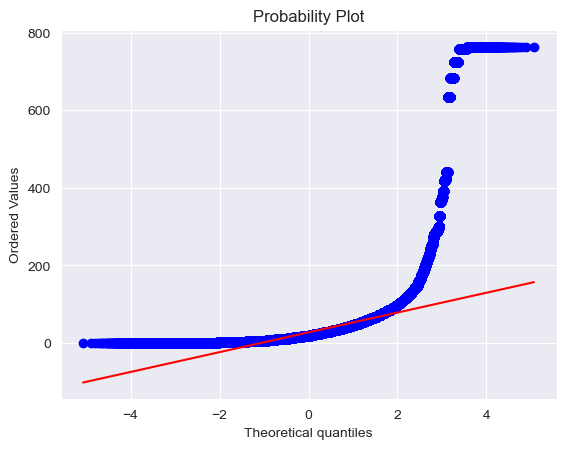

user_avg_rating


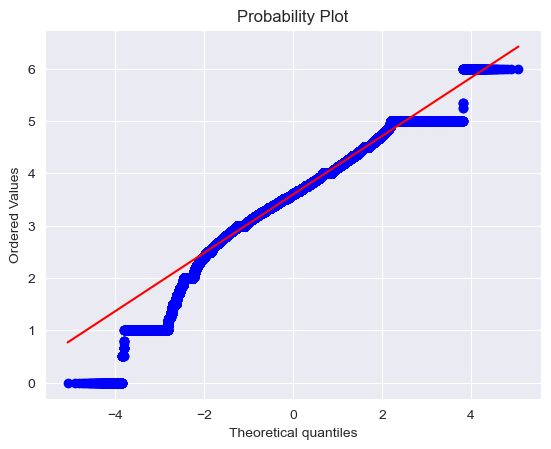

user_std_rating


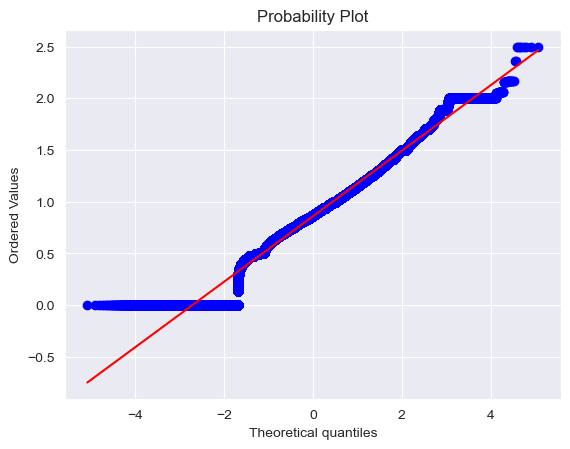

user_min_rating


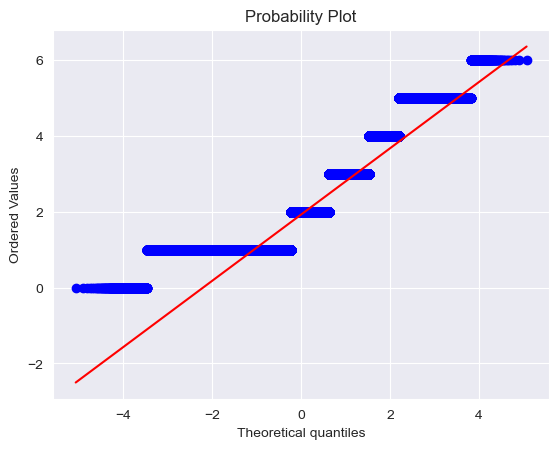

user_max_rating


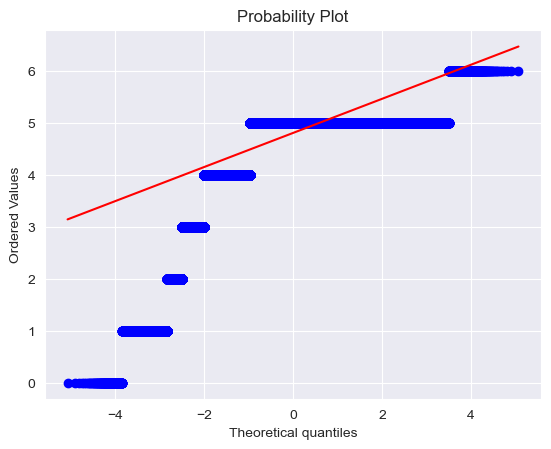

unique_movies


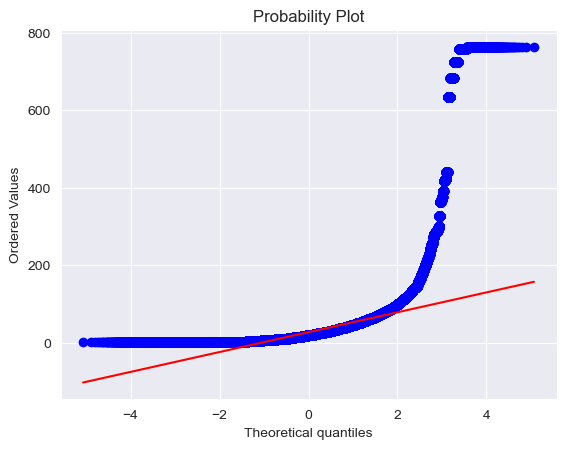

activity_days


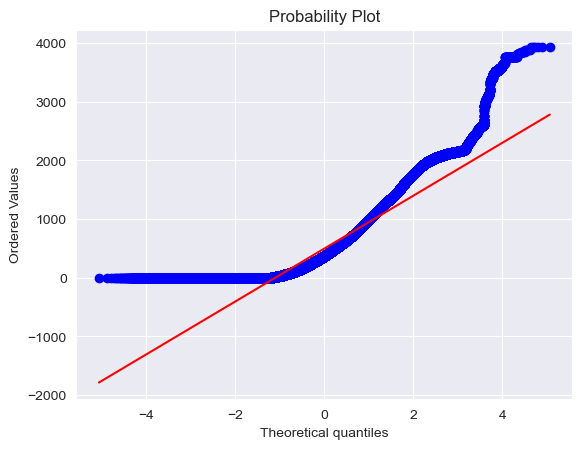

movie_total_ratings


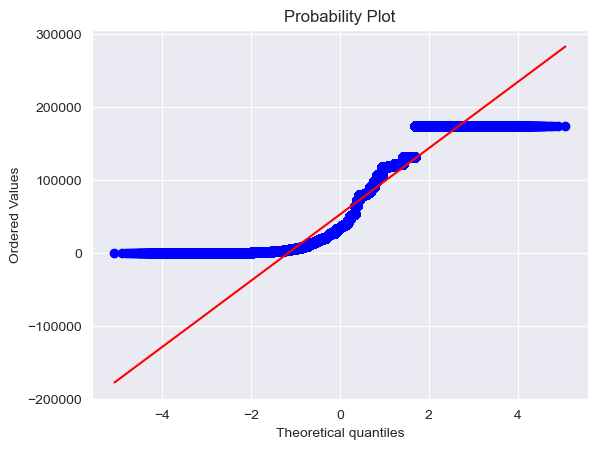

movie_avg_rating


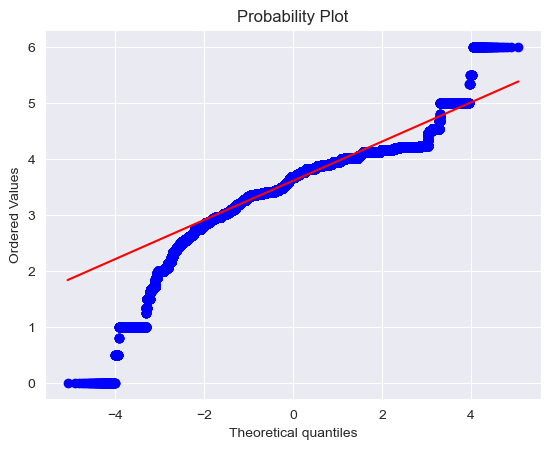

movie_std_rating


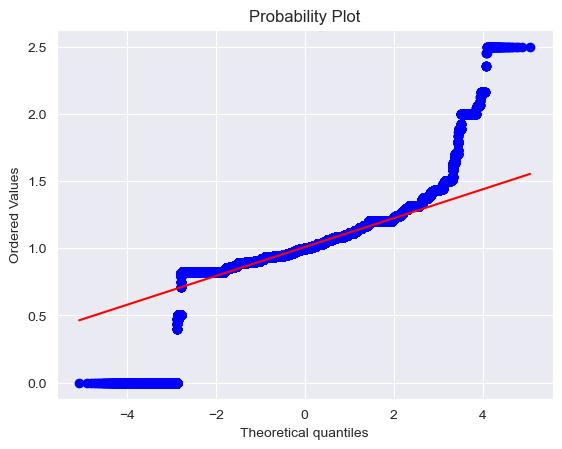

movie_min_rating


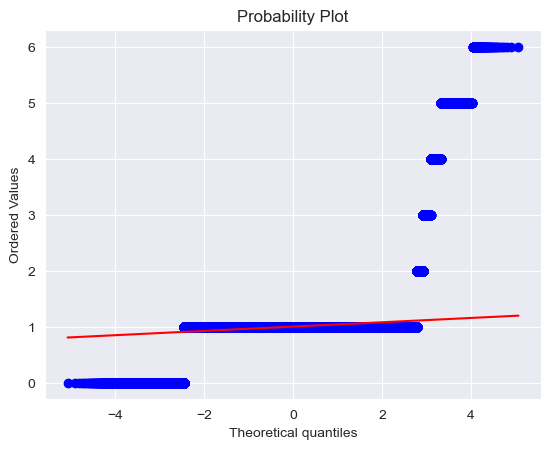

movie_max_rating


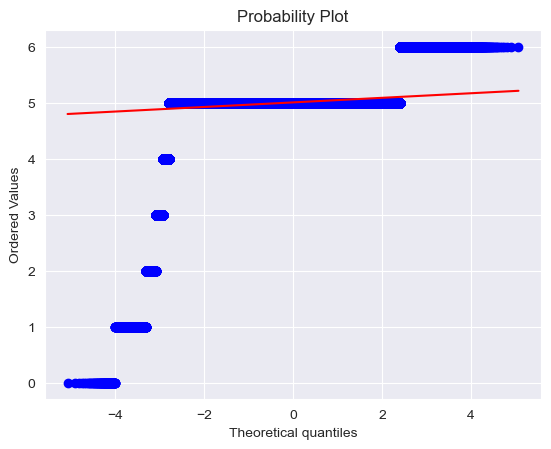

In [106]:
for ud in user_features_full:
    print(ud)
    plot_data_distribution(merged_data[ud])

for md in movie_features:
    print(md)
    plot_data_distribution(merged_data[md])

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Kernel Density Estimation Test</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
KDE reveals whether the data forms distinct dense regions (potential clusters) or whether it is one continuous mass with no meaningful separation.

**Behaviour:**<br>
Gets 2D PCA-transformed data (pca_data[:,0], pca_data[:,1]) as inputs, then estimates the probability density function of the data by smoothing individual points. It overlays a continuous heatmap on the scatter plot, showing where points densely accumulate v/s where they are sparse.

**Interpretation:**<br>
The brighter -  the higher density.
Smooth gradients - no clear cluster structure.

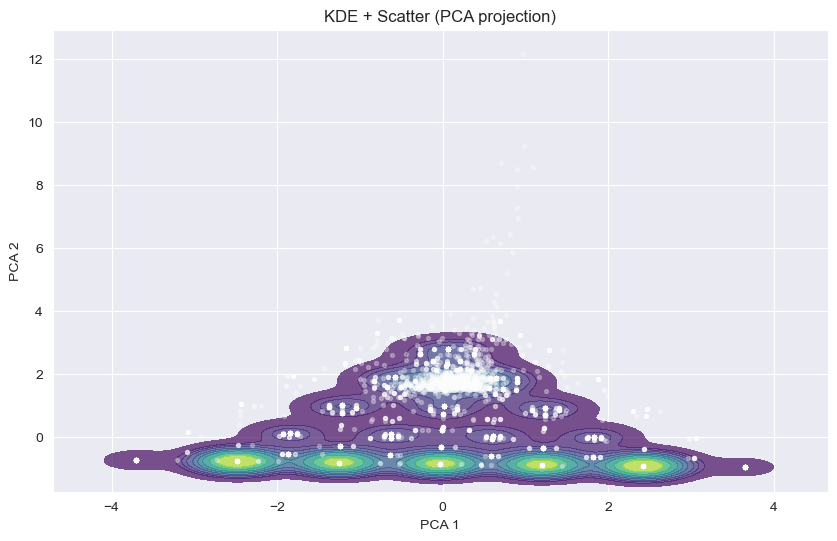

In [107]:
X = movies_for_clustering[movie_features].astype(float).dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=pca_data[:, 0],
    y=pca_data[:, 1],
    fill=True,
    cmap="viridis",
    alpha=0.7,
    thresh=0.05,
)

plt.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    s=8,
    color="white",
    alpha=0.3,
    edgecolor=None
)

plt.title("KDE + Scatter (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

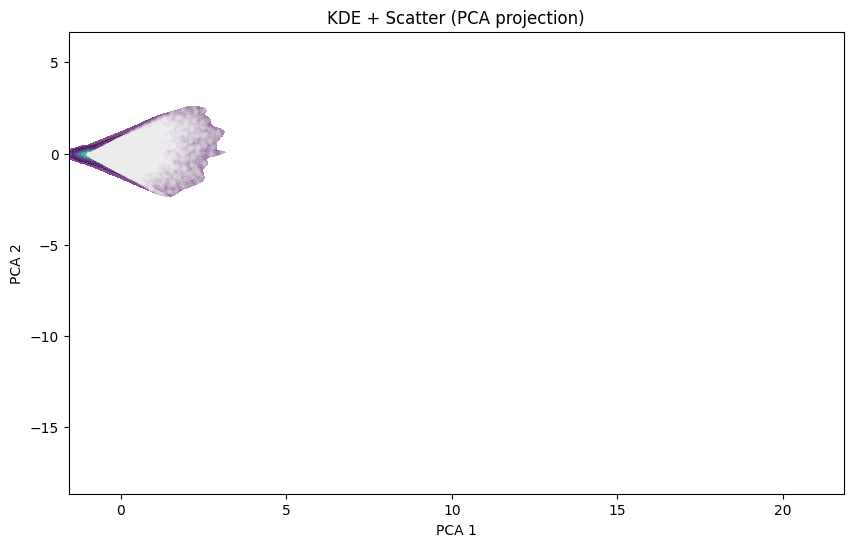

In [ ]:
Y = reduced_user_sample[user_features_full].astype(float).dropna()


scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(Y_scaled)

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=pca_data[:, 0],
    y=pca_data[:, 1],
    fill=True,
    cmap="viridis",
    alpha=0.7,
    thresh=0.05,
)

plt.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    s=8,
    color="white",
    alpha=0.05,
    edgecolor=None
)

plt.title("KDE + Scatter (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>KNN Stats</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Checks whether the dataset has natural cluster structure by analyzing how close each point is to its neighbors.
If real clusters exist, points inside a cluster should have similar and small neighbor distances, while points between clusters should have larger distances.

**Behaviour:**<br>
For every point, the algorithm finds its 10 nearest neighbors. It then computes the mean distance to these 10 neighbors. And then it can get the standard deviation of these mean distances and the average (mean of means).

**Interpretation:**<br>
std > mean: strong signs of cluster-like structure or density separation.<br>
std ≈ mean: mild structure, maybe weak clusters.<br>
std < mean: very uniform data which is poor for clustering.


In [109]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(X_scaled)

distances, _ = nn.kneighbors(X_scaled)
mean_d = distances.mean(axis=1)

print("Std of mean distances:", np.std(mean_d))
print("Mean of mean distances:", np.mean(mean_d))

Std of mean distances: 0.2054481524478132
Mean of mean distances: 0.02719994306263813


In [110]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(Y_scaled)

distances, _ = nn.kneighbors(Y_scaled)
mean_d = distances.mean(axis=1)

print("Std of mean distances:", np.std(mean_d))
print("Mean of mean distances:", np.mean(mean_d))

Std of mean distances: 0.207486152521621
Mean of mean distances: 0.1495436800634765


<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Distance distribution test</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Helps to understand how all points in the dataset relate to each other in terms of distance.
It checks whether the dataset contains distinct separation gaps (which would indicate clusters) or if distances form one continuous distribution (which suggests no clear cluster structure).

**Behaviour:**<br>
Computes all pairwise distances between all points, flattens them into a single vector (flat), and plots a histogram showing how frequently each distance value occurs.

**Interpretation:**<br>
Multiple peaks: different groups of distances, potential cluster separation.<br>
One smooth peak: distances vary gradually, no meaningful clustering structure.<br>
Long tails: possible outliers or density imbalance.

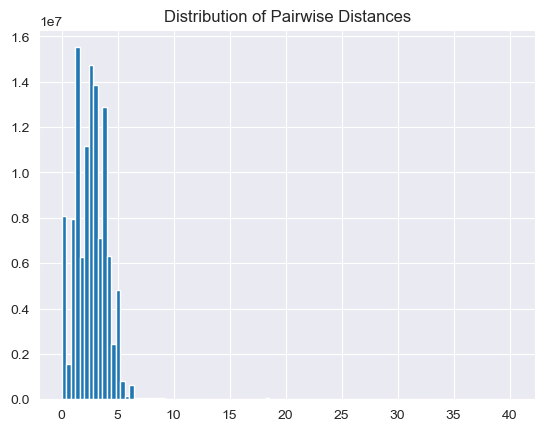

In [111]:
dists = pairwise_distances(X_scaled)
flat = dists.flatten()

plt.hist(flat, bins=100)
plt.title("Distribution of Pairwise Distances")
plt.show()

In [112]:
#scaler = StandardScaler()
#reduced_user_sample_scaled = scaler.fit_transform(reduced_user_sample)

#dists = pairwise_distances(reduced_user_sample_scaled)

#flat = dists.flatten()

#plt.figure(figsize=(7, 4))
#plt.hist(flat, bins=100)
#plt.title("Distribution of Pairwise Distances (reduced sample)")
#plt.xlabel("Distance")
#plt.ylabel("Frequency")
#plt.show()

#too expensive to run for users, my pc dies twice

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Hopkins test</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Tells if our data is clusterrable at all

**Behaviour:**<br>
Randomly selects a subset of real points (X_sample), generates the same number of points uniformly at random within the data space (X_uniform). Then for each:
* measures distance from uniform points to the nearest real point: U
* measures distance from sampled real points to their nearest neighbor: W

Finally, Computes Hopkins = U / (U + W).

**Interpretation:**<br>
H ≈ 0.5: random / uniform distribution (no clusters). <br>
H = 1.0: data is highly clusterable.<br>
H = 0.0: data is overly regular (grid-like), also no natural clusters.

In [113]:
def hopkins(X, sampling=0.1, random_state=42):
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    np.random.seed(random_state)

    X = np.asarray(X)
    n_samples, d = X.shape

    m = int(np.ceil(sampling * n_samples))
    if m <= 0:
        raise ValueError("Sampling too small, m=0")

    idx = np.random.choice(n_samples, m, replace=False)
    X_sample = X[idx]

    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_uniform = np.random.uniform(X_min, X_max, size=(m, d))

    nn_for_uniform = NearestNeighbors(n_neighbors=1).fit(X)
    nn_for_sample = NearestNeighbors(n_neighbors=2).fit(X)

    u_dist, _ = nn_for_uniform.kneighbors(X_uniform)
    w_dist_full, _ = nn_for_sample.kneighbors(X_sample)
    w_dist = w_dist_full[:, 1]

    U = u_dist[:, 0].sum()
    W = w_dist.sum()

    return U / (U + W)

H = hopkins(X_scaled, sampling=0.1) # hopkins for movies
H_1 = hopkins(Y_scaled) # hopkins for users
print("Hopkins statistic:", H)
print('-----------')
print("Hopkins statistic:", H_1)

Hopkins statistic: 0.9964931143449774
-----------
Hopkins statistic: 0.9889318913440988


<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Cumulative explained variance test</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
To understand how much of the dataset’s total variance can be captured with a reduced number of principal components.
This helps evaluate whether the data is high-dimensional with complex structure, or whether most variation lies in just a few directions (which often indicates redundancy or low intrinsic dimensionality).

**Behaviour:**<br>
Fits PCA on all features without specifying the number of components. Then computes the explained variance ratio (variance contribution of each component) and cumulative explained variance (how much total variance is captured after adding each component). Lastly, it plots the cumulative curve to visualize how quickly variance saturates.

**Interpretation:**<br>
Shows a graph with PCA to variance corelation

Explained variance ratio: [0.492 0.298 0.193 0.014 0.003]
Cumulative: [0.492 0.79  0.984 0.997 1.   ]


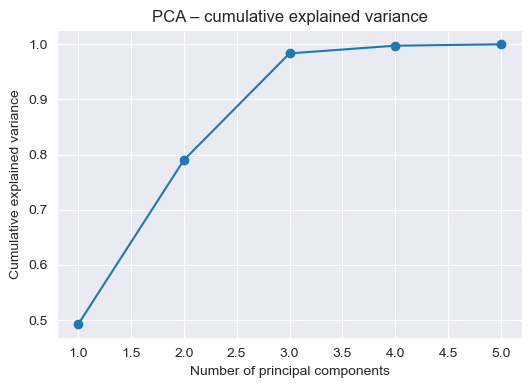

In [114]:
pca = PCA()
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print("Explained variance ratio:", np.round(explained, 3))
print("Cumulative:", np.round(cum_explained, 3))

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained) + 1), cum_explained, marker="o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – cumulative explained variance")
plt.grid(True)
plt.show()

#too expensive for users

### Plotting Statistics and Overall findings

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Plotting Ditribution of Viewer Ratings</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Show case the Distribution of the Viewer ratings

**Showcasing:**<br>
There is a clear over positive bias. This can be due to the fact that this was done on a streaming platform where users are more likely to rate higher

**Output:**<br>
Histogram showcasing Distribution of viewer ratings


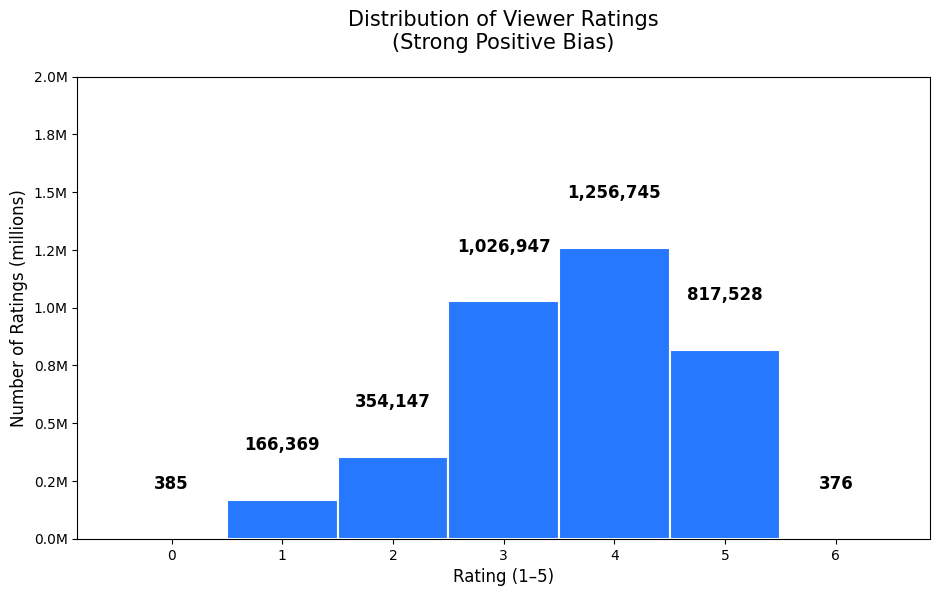

In [81]:
sync_dataframe(viewer_ratings)
plt.figure(figsize=(11, 6)) 
ax = sns.histplot(
    data=dfs['viewer_ratings'],
    x='rating',
    bins=5,
    discrete=True, 
    color="#0062ff",
    edgecolor='white',
    alpha=0.85,
    linewidth=1.5
)

# Add exact counts on top of each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2., 
        height + 200_000,                    # a bit above the bar
        f'{int(height):,}',                  # adds commas
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

# y-axis
plt.ylabel('Number of Ratings (millions)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M')) # format in millions

plt.title('Distribution of Viewer Ratings\n(Strong Positive Bias)', 
          fontsize=15, pad=20)
plt.xlabel('Rating (1–5)', fontsize=12)
plt.xticks(range(0, 7))
plt.ylim(0, 2_000_000)
plt.show()

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Plotting Average Rating Over Time</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Viewing the years with the most engaging/interacted with movies

**Showcasing:**<br>
Plotting a timeline of average ratings over time, it showcases that the movies released in the 2000s have the most engagment, and we can clearly see that majority of the ratings over the years seem to be inbetween 2 and 4

**Output:**<br>
Plots a scatter plot showing all the average ratings with the x-axis containing the year the movie was released

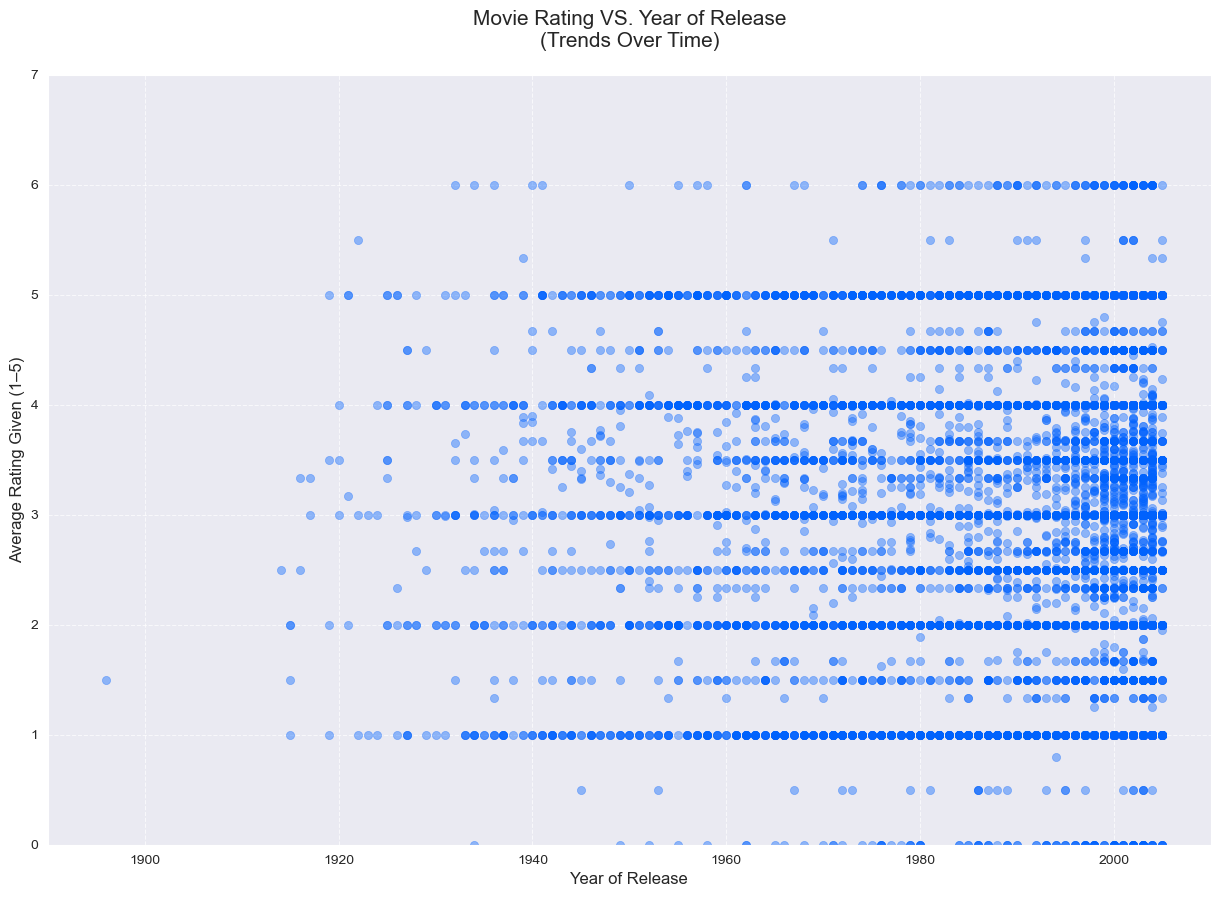

In [ ]:
'Plotting a timeline of ratings over time'

sync_dataframe(movies_stats)

plt.figure(figsize=(15, 10))
sns.scatterplot(data=movies_stats, x='year_of_release', y='avg_rating', alpha=0.4, color='#0062ff', edgecolor=None, s=35)
plt.title('Movie Rating VS. Year of Release\n(Trends Over Time)', fontsize=15, pad=20)
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Average Rating Given (1–5)', fontsize=12)
plt.xlim(1890, 2010) #this included the data for all the movies in the data set as it goes from 1896 to 2005
plt.ylim(0, 7)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<div style="display:flex; align-items:center;">
  <hr style="flex:1;">
  <span style="padding:0 10px;"><b>Plotting Top 10 Movies</b></span>
  <hr style="flex:1;">
</div>

**Purpose:**<br>
Showcasing top seller movies visually

**Showcasing:**<br>
Showcases the top 10 movies in the movie statistics based on average rating. Also we make a minimum of 1000 rating to get rid of the problem for getting movies with 1 really high rating. In the plot we can see that still the most popular movie has less engagement then the ones on the bottom, thius showcases that problem regarding the minimum number of interaction/ratings.

**Output:**<br>
Plots a horizontal bar chart that shows the top rated movies with there average rating, total ratings, year of release, and movie title

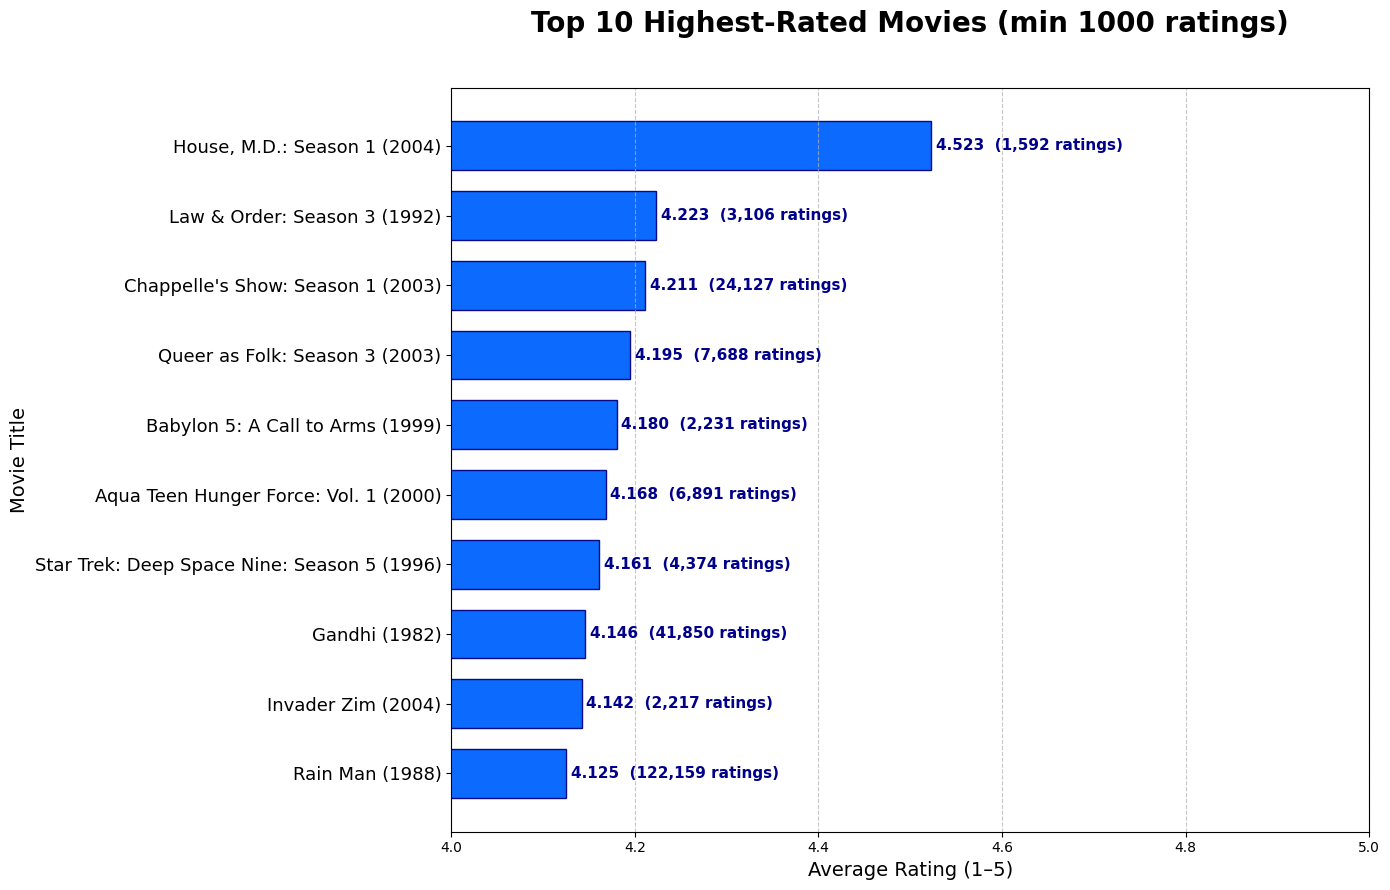

In [ ]:
def get_top_rated_movies(min_ratings=200, top_n=10):
    sync_dataframe(movies_stats)
    
    # Filter and sort — pure movie_statistics
    filtered = movies_stats[movies_stats['total_ratings'] >= min_ratings]
    top_movies = filtered.sort_values('avg_rating', ascending=False).head(top_n).copy()
    
    # Reset index to get ranking 1 to 10
    top_movies = top_movies.reset_index(drop=True)
    top_movies.index = top_movies.index + 1
    
    # Get titles
    titles = []
    for movie_id in top_movies['movie_id']:
        result = search_by_parameter("movies", "movie_id", movie_id)
        title = result['title'].iloc[0] if not result.empty else f"Unknown ({movie_id})"
        year = int(result['year_of_release'].iloc[0]) if not result.empty and pd.notna(result['year_of_release'].iloc[0]) else ""
        titles.append(f"{title} ({year})" if year else title)
    
    top_movies['title_display'] = titles
    return top_movies

# Calling the function for top 10 movies with at least 1000 ratings
top10 = get_top_rated_movies(min_ratings=1000, top_n=10)

plt.figure(figsize=(14, 9))

top10_Reversed = top10.sort_values('avg_rating', ascending=True)

bars = plt.barh(
    y=top10_Reversed['title_display'],
    width=top10_Reversed['avg_rating'],
    color='#0062ff',
    edgecolor='navy',
    height=0.7,
    alpha=0.95
)

# Adding the exact rating + number of ratings on each bar
for bar, row in zip(bars, top10_Reversed.itertuples()):
    plt.text(
        x=bar.get_width() + 0.005,                    # slightly right of bar
        y=bar.get_y() + bar.get_height()/2,           # center vertically
        s=f"{row.avg_rating:.3f}  ({row.total_ratings:,} ratings)",
        va='center',
        ha='left',
        fontsize=11,
        fontweight='bold',
        color='darkblue'
    )

plt.title('Top 10 Highest-Rated Movies (min 1000 ratings)', 
          fontsize=20, pad=40, fontweight='bold')
plt.xlabel('Average Rating (1–5)', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.xlim(4.0, 5.0)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

### Models

K-means clustering model for movies

Added NEW df: global 'movie_clusters' → dfs['movie_clusters']


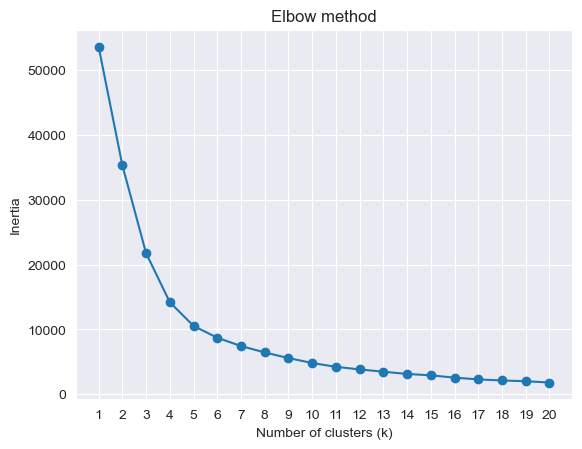

     k       inertia
0    1  53645.000000
1    2  35356.903769
2    3  21792.244121
3    4  14212.141516
4    5  10550.316491
5    6   8727.345741
6    7   7445.375262
7    8   6457.401689
8    9   5589.988991
9   10   4825.679192
10  11   4236.626670
11  12   3838.100285
12  13   3481.499489
13  14   3141.156327
14  15   2924.652035
15  16   2565.227703
16  17   2298.990581
17  18   2133.104870
18  19   2013.901453
19  20   1817.411801
---movies in each cluster--- 
cluster_id
0    3248
1    4434
2      19
3    3028
Name: count, dtype: int64
0.540967661736605


,movie_id,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,cluster_id
count,3248.000000,3248.0,3248.000000,3248.000000,3248.000000,3248.000000,3248.0
mean,9135.271552,1.355603,1.513588,0.085862,1.372537,1.649938,0.0
std,5251.883610,0.605965,0.603185,0.202594,0.579718,0.755430,0.0
min,228.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,4760.250000,1.0,1.000000,0.000000,1.000000,1.000000,0.0
50%,9089.500000,1.0,1.500000,0.000000,1.000000,2.000000,0.0
75%,13554.250000,2.0,2.000000,0.000000,2.000000,2.000000,0.0
max,24967.000000,5.0,3.500000,1.000000,3.000000,4.000000,0.0


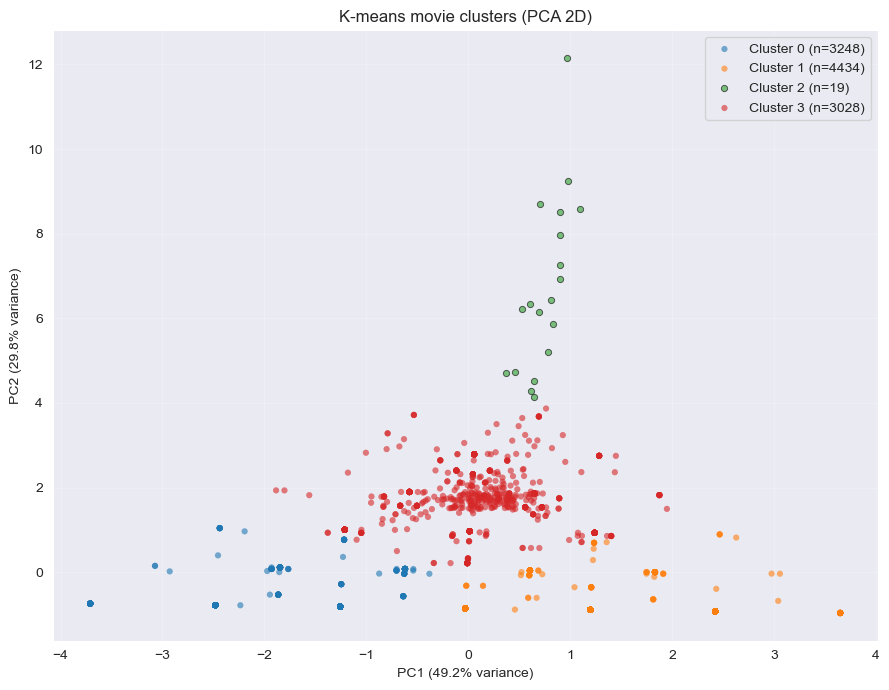

In [122]:
sync_dataframe(merged_data)

# making a table 1 row - 1 movie
movies_for_clustering = (
    merged_data
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

# getting all number variables except for movie_id
X = movies_for_clustering[movie_features].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# number of clusters
n_clusters = 4

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X_scaled)

# adding cluster ids to the table
movies_for_clustering["cluster_id"] = cluster_labels

# saving
add_new_df('movie_clusters', 'movie_clusters', movies_for_clustering)

elbow_df = elbow_method(X_scaled, 1, 20)
print(elbow_df)

# printing how many movies in each cluster, only for debugging
cluster_movies_amount_str = movies_for_clustering["cluster_id"].value_counts().sort_index()
print(f"---movies in each cluster--- \n{cluster_movies_amount_str}")
# Silhouette score
print(compute_silhouette_score(X_scaled, cluster_labels))

inspect_movie_cluster(movies_for_clustering, merged_data, 0)
plot_clusters_pca_2d(X_scaled, cluster_labels, max_points_per_cluster=800)

K-means clustering model for movies without the outliers

Added NEW df: global 'movie_clusters_no3' → dfs['movie_clusters_no3']


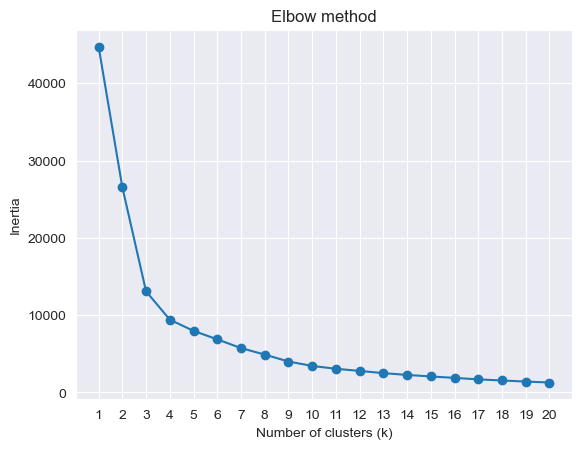

--- Elbow after removing old cluster 3 ---
     k       inertia
0    1  44763.734892
1    2  26577.585624
2    3  13083.720906
3    4   9417.935311
4    5   7962.151260
5    6   6868.539322
6    7   5734.715641
7    8   4897.220389
8    9   3998.158473
9   10   3423.594387
10  11   3057.094112
11  12   2779.528992
12  13   2492.988148
13  14   2262.010661
14  15   2063.031363
15  16   1878.009907
16  17   1687.059635
17  18   1541.283364
18  19   1402.060131
19  20   1279.282825
--- movies in each NEW cluster (old cluster 3 removed) ---
cluster_id
0    3028
1    3248
2    4434
Name: count, dtype: int64
--- Silhouette score (no old cluster 3) ---
0.5410448513347945


,movie_id,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,cluster_id
count,3028.000000,3028.0,3028.000000,3028.000000,3028.000000,3028.000000,3028.0
mean,8654.745707,725.835865,3.059756,1.280301,1.380119,4.651255,0.0
std,5521.162692,3390.858879,0.633808,0.424073,0.703825,0.701060,0.0
min,1.000000,2.0,1.333333,0.000000,0.000000,3.000000,0.0
25%,4355.750000,2.0,2.572604,1.000000,1.000000,4.000000,0.0
50%,9048.000000,3.0,3.000000,1.204642,1.000000,5.000000,0.0
75%,13382.250000,5.0,3.500000,1.500000,2.000000,5.000000,0.0
max,24825.000000,41850.0,4.750000,2.500000,3.000000,6.000000,0.0


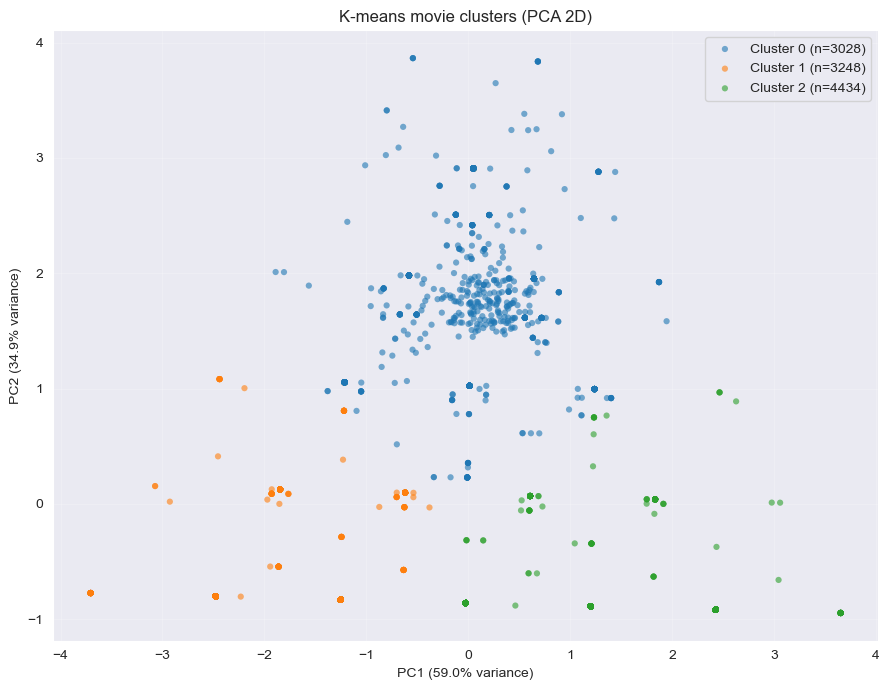

In [123]:
mask_no3 = movies_for_clustering["cluster_id"] != 2
movies_no3 = movies_for_clustering[mask_no3].copy()

X_scaled_no3 = X_scaled[mask_no3.values]

# Re-run KMeans on the reduced dataset
n_clusters_new = 3  # keep 4 to see how cluster structure changes after removing old cluster 3

kmeans_no3 = KMeans(
    n_clusters=n_clusters_new,
    random_state=42,
    n_init=10
)

cluster_labels_no3 = kmeans_no3.fit_predict(X_scaled_no3)

# Attach the *new* cluster ids
# (original movies_for_clustering is untouched, we work only on movies_no3)
movies_no3["cluster_id"] = cluster_labels_no3

# Save as a separate df in dfs
add_new_df("movie_clusters_no3", "movie_clusters_no3", movies_no3)

# Elbow on the reduced dataset (optional, to see if k changed)
elbow_df_no3 = elbow_method(X_scaled_no3, 1, 20)
print("--- Elbow after removing old cluster 3 ---")
print(elbow_df_no3)

# Cluster sizes for the new run
cluster_movies_amount_str_no3 = movies_no3["cluster_id"].value_counts().sort_index()
print("--- movies in each NEW cluster (old cluster 3 removed) ---")
print(cluster_movies_amount_str_no3)

# Silhouette score for the new clustering
print("--- Silhouette score (no old cluster 3) ---")
print(compute_silhouette_score(X_scaled_no3, cluster_labels_no3))

# Quick inspection of one of the new clusters (e.g., cluster 0)
inspect_movie_cluster(movies_no3, merged_data, 0)

# PCA 2D visualization for the new clustering
plot_clusters_pca_2d(X_scaled_no3, cluster_labels_no3, max_points_per_cluster=800)

Agglomerative clustering model for movies

   movie_id  movie_total_ratings  movie_avg_rating  movie_std_rating  movie_min_rating  movie_max_rating
0         1                  548          3.744526          1.089920               1.0               5.0
1         2                  146          3.547945          1.279922               1.0               5.0
2         3                 2013          3.639841          0.977014               1.0               5.0
3         4                  142          2.739437          1.279748               1.0               5.0
4         5                 1140          3.919298          1.288186               1.0               5.0


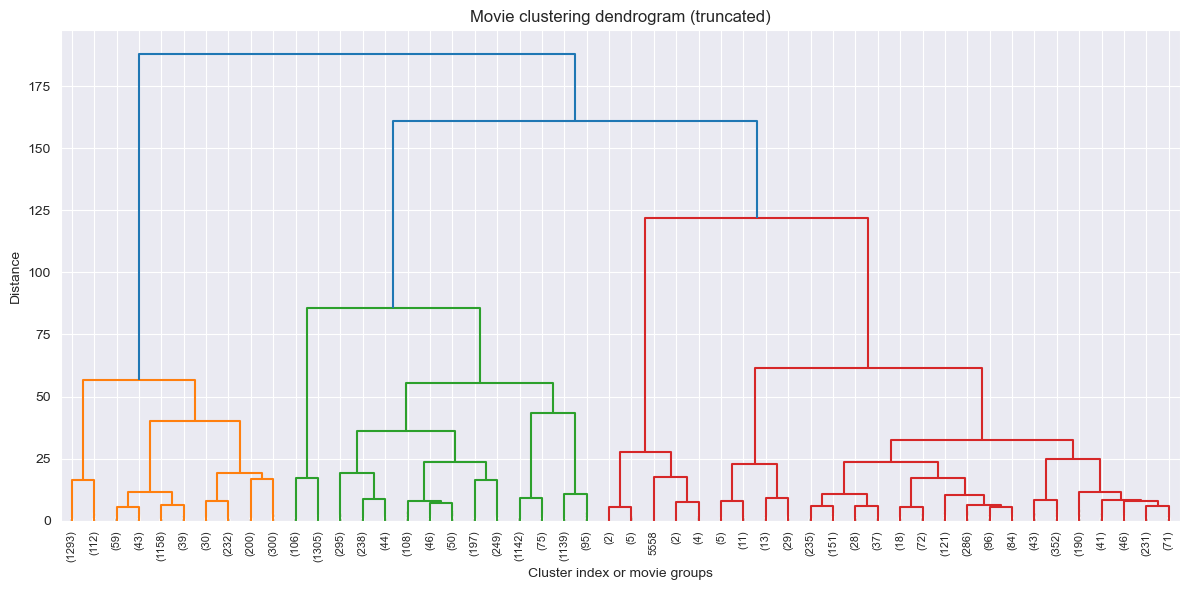

---movies in each cluster--- 
cluster_id
0    3466
1    5089
2      14
3    2160
Name: count, dtype: int64
0.5076841782654569
Added NEW df: global 'movie_clusters_h' → dfs['movie_clusters_h']


,movie_id,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,cluster_id
count,3466.000000,3466.0,3466.000000,3466.000000,3466.000000,3466.000000,3466.0
mean,9145.624062,1.419792,4.450130,0.154510,4.260531,4.640796,0.0
std,5243.147737,0.646045,0.584302,0.308891,0.769127,0.563383,0.0
min,231.000000,1.0,2.500000,0.000000,3.000000,4.000000,0.0
25%,4752.500000,1.0,4.000000,0.000000,4.000000,4.000000,0.0
50%,8929.000000,1.0,4.333333,0.000000,4.000000,5.000000,0.0
75%,13668.250000,2.0,5.000000,0.000000,5.000000,5.000000,0.0
max,24974.000000,5.0,6.000000,1.000000,6.000000,6.000000,0.0


,movie_id,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,cluster_id,title
0,231,1,5.000000,0.0,5.0,5.0,0,Marooned in Iraq
1,251,3,3.666667,0.5,3.0,4.0,0,Midsomer Murders: Strangler's Wood
2,254,1,5.000000,0.0,5.0,5.0,0,Westender
3,256,1,5.000000,0.0,5.0,5.0,0,Ghost Dog: The Way of the Samurai
4,261,1,4.000000,0.0,4.0,4.0,0,The Big Clock
...,...,...,...,...,...,...,...,...
3461,24374,3,3.333333,0.5,3.0,4.0,0,Legend of Stranger
3462,24742,2,3.500000,0.5,3.0,4.0,0,Light of Princess
3463,24782,1,4.000000,0.0,4.0,4.0,0,Woman's Dream
3464,24913,3,5.000000,0.0,5.0,5.0,0,Dark Empire


In [124]:
sync_dataframe(merged_data)

# One row per movie
movies_for_h_clustering = (
    merged_data
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

print(movies_for_h_clustering.head())

# Matrix of fs
X = movies_for_h_clustering[movie_features].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Z = linkage(X_scaled, method="ward")

# Building a dendogram
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=50,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True
)
plt.title("Movie clustering dendrogram (truncated)")
plt.xlabel("Cluster index or movie groups")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

n_clusters = 4  # number of clusters

h_cluster_labels = fcluster(Z, t=n_clusters, criterion="maxclust")

movies_for_h_clustering["cluster_id"] = h_cluster_labels - 1

# printing how many movies in each cluster, only for debugging
h_cluster_movies_amount_str = movies_for_h_clustering["cluster_id"].value_counts().sort_index()
print(f"---movies in each cluster--- \n{h_cluster_movies_amount_str}")
# Silhouette score
hier_labels = movies_for_h_clustering["cluster_id"].to_numpy()
print(compute_silhouette_score(X_scaled, hier_labels))

# saving
add_new_df("movie_clusters_h", "movie_clusters_h", movies_for_h_clustering)
inspect_movie_cluster(movie_clusters_h, merged_data, 0)

GMM clustering model for movies

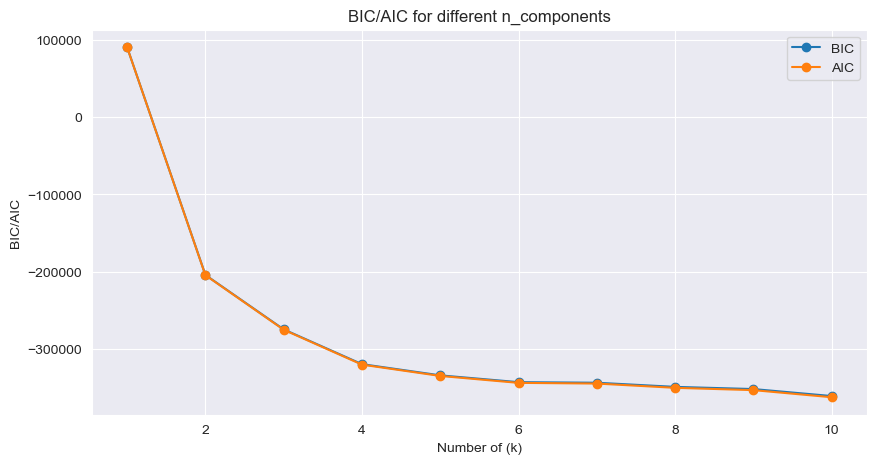

In [125]:
sync_dataframe(merged_data)

movies_for_gmm = (
    merged_data
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

X = movies_for_gmm[movie_features].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_values = range(1, 11)
bic_values = []
aic_values = []

for k in k_values:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42,
        n_init=5
    )
    gmm.fit(X_scaled)

    bic_values.append(gmm.bic(X_scaled))
    aic_values.append(gmm.aic(X_scaled))

plt.figure(figsize=(10, 5))
plt.plot(k_values, bic_values, marker="o", label="BIC")
plt.plot(k_values, aic_values, marker="o", label="AIC")
plt.title("BIC/AIC for different n_components")
plt.xlabel("Number of (k)")
plt.ylabel("BIC/AIC")
plt.legend()
plt.grid(True)
plt.show()

Added NEW df: global 'movie_clusters_gmm' → dfs['movie_clusters_gmm']
GMM silhouette score: 0.1473


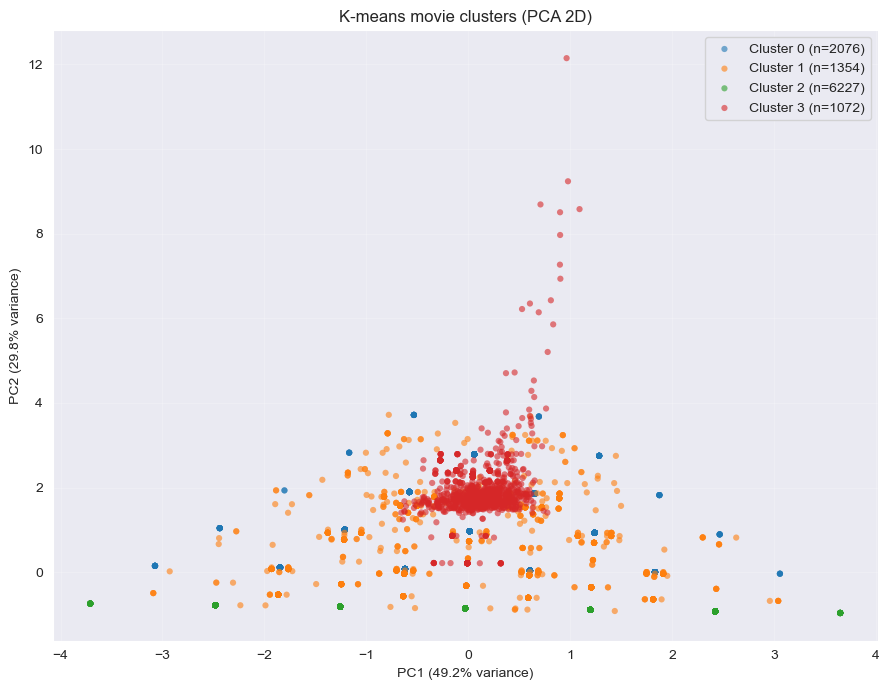

In [126]:
sync_dataframe(merged_data)

movies_for_clustering_gmm = (
    merged_data
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

X = movies_for_clustering_gmm[movie_features].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm = GaussianMixture(
    n_components=4,
    covariance_type="full",
    random_state=42,
    n_init=10
)

gmm_labels = gmm.fit_predict(X_scaled)

movies_for_clustering_gmm["gmm_cluster_id"] = gmm_labels

add_new_df("movie_clusters_gmm","movie_clusters_gmm",movies_for_clustering_gmm)

gmm_s_score = compute_silhouette_score(
    X_scaled,
    gmm_labels,
)

print(f"GMM silhouette score: {gmm_s_score:.4f}")
plot_clusters_pca_2d(X_scaled, gmm_labels)

DBSCAN clustering model for movies

dbscan_cluster_id
-1       86
 0     3017
 1     1139
 2     1293
 3      197
 4     3125
 5      200
 6     1158
 7      238
 8      106
 9       21
 10      30
 11      94
 12      25
Name: count, dtype: int64
Clusters: 13
Noise: 86
Silhouette: 0.36395245772725854


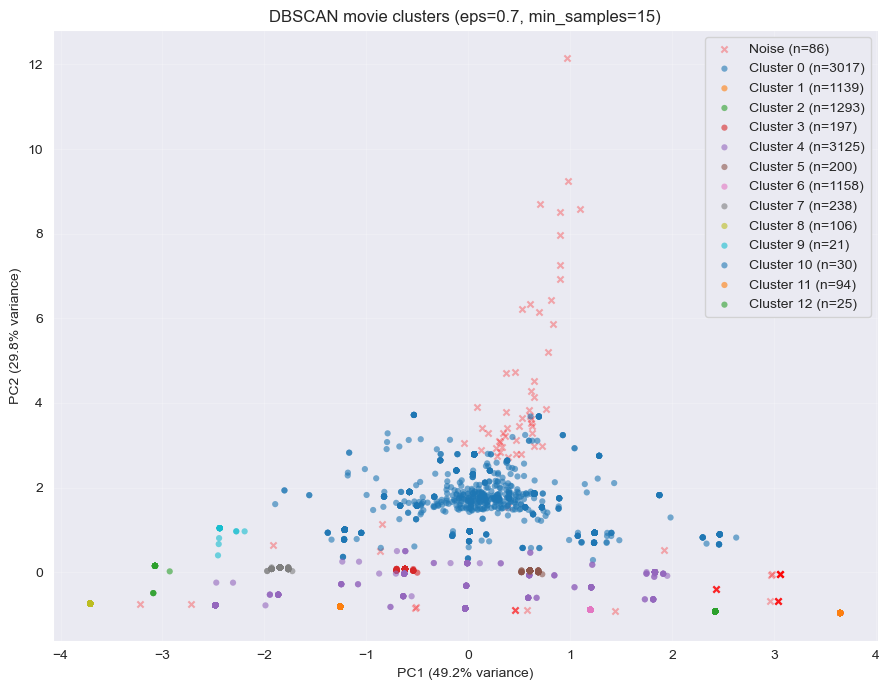

In [127]:
eps = 0.7
min_samples = 15

dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    metric="euclidean",
    n_jobs=-1
)

labels = dbscan.fit_predict(X_scaled)

movies_for_clustering_db = (
    merged_data
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

movies_for_clustering_db["dbscan_cluster_id"] = labels

cluster_counts = (
    movies_for_clustering_db["dbscan_cluster_id"]
    .value_counts()
    .sort_index()
)

print(cluster_counts)

unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
noise = (labels == -1).sum()

print(f"Clusters: {n_clusters}")
print(f"Noise: {noise}")

mask = labels != -1
if n_clusters > 1 and mask.sum() > 0:
    sil = compute_silhouette_score(X_scaled[mask], labels[mask])
    print("Silhouette:", sil)

plot_dbscan_pca_2d(
    X_scaled,
    labels,
    max_points_per_cluster=1000,
    title=f"DBSCAN movie clusters (eps={eps}, min_samples={min_samples})"
)

In [128]:
eps_list = [.3, .4, 0.50, 0.60, 0.70, 0.75, 0.85, 1.0]

def test_eps_values(X_scaled, eps_list, min_samples=15):
    print("eps  | clusters | noise | silhouette")
    print("-------------------------------------")

    for eps in eps_list:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise = (labels == -1).sum()

        if n_clusters > 1:
            mask = labels != -1
            sil = compute_silhouette_score(X_scaled[mask], labels[mask])
            sil = round(sil, 3)
        else:
            sil = None

        print(f"{eps:<4} | {n_clusters:<8} | {noise:<5} | {sil}")

test_eps_values(X_scaled, eps_list)

eps  | clusters | noise | silhouette
-------------------------------------
0.3  | 34       | 415   | 0.853
0.4  | 36       | 315   | 0.837
0.5  | 38       | 210   | 0.827
0.6  | 37       | 153   | 0.819
0.7  | 13       | 86    | 0.364
0.75 | 3        | 63    | 0.072
0.85 | 1        | 43    | None
1.0  | 1        | 32    | None


K-means clustering model for users

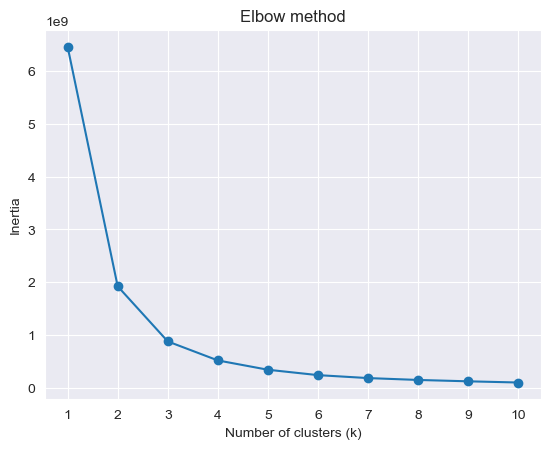

    k       inertia
0   1  6.465990e+09
1   2  1.924044e+09
2   3  8.796863e+08
3   4  5.196878e+08
4   5  3.432289e+08
5   6  2.413252e+08
6   7  1.854245e+08
7   8  1.499762e+08
8   9  1.241065e+08
9  10  1.014859e+08
cluster_id
0    17543
1    19178
2     5180
Name: count, dtype: int64
0.326727358665598


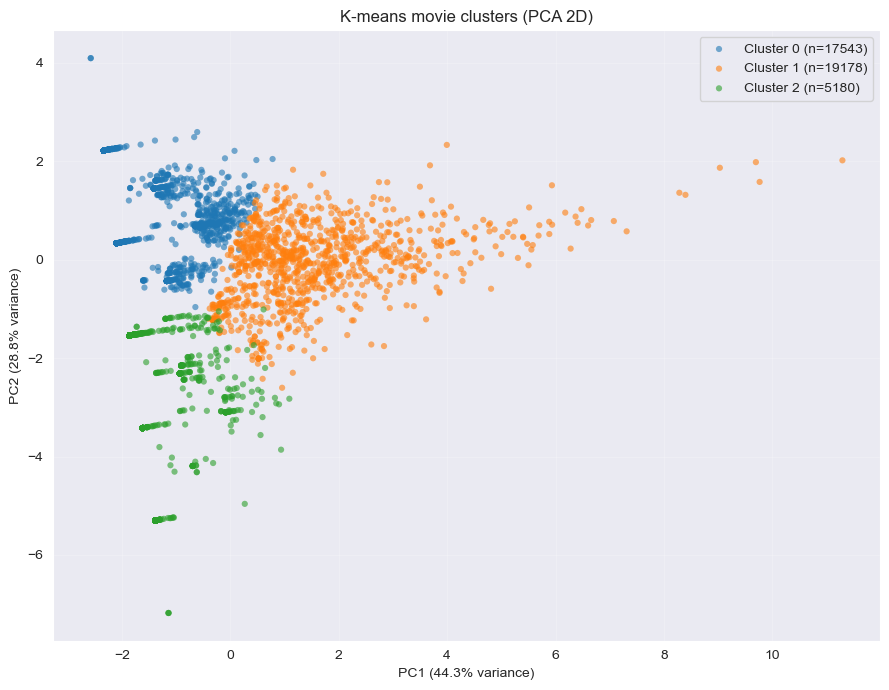

In [129]:
sync_dataframe(merged_data)
data = merged_data.copy()

# Taking first row per user
users_for_clustering = (
    data.groupby("customer_id")[user_features_full]
    .first()
    .reset_index()
)

data = reduced_user_sample[user_features_full].astype(float)
data = data[user_features_full].dropna()

scalar = StandardScaler()
scaled_data = scalar.fit_transform(data)

print(elbow_method(data))

# k-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(scaled_data)

reduced_user_sample["cluster_id"] = cluster_labels
print(reduced_user_sample["cluster_id"].value_counts().sort_index())
print(compute_silhouette_score(scaled_data, cluster_labels, 20000))

plot_clusters_pca_2d(scaled_data, cluster_labels)

#add_new_df("user_clusters", "user_clusters", users_for_clustering)

K-means clustering model for users (two most significant)

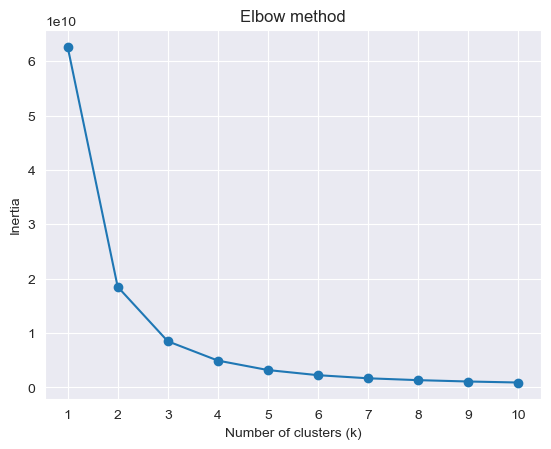

    k       inertia
0   1  6.270793e+10
1   2  1.850728e+10
2   3  8.487615e+09
3   4  4.934213e+09
4   5  3.191750e+09
5   6  2.247933e+09
6   7  1.677557e+09
7   8  1.335321e+09
8   9  1.086570e+09
9  10  9.004319e+08
cluster_id
0    321506
1     70713
2     26794
Name: count, dtype: int64
0.6113911220329635


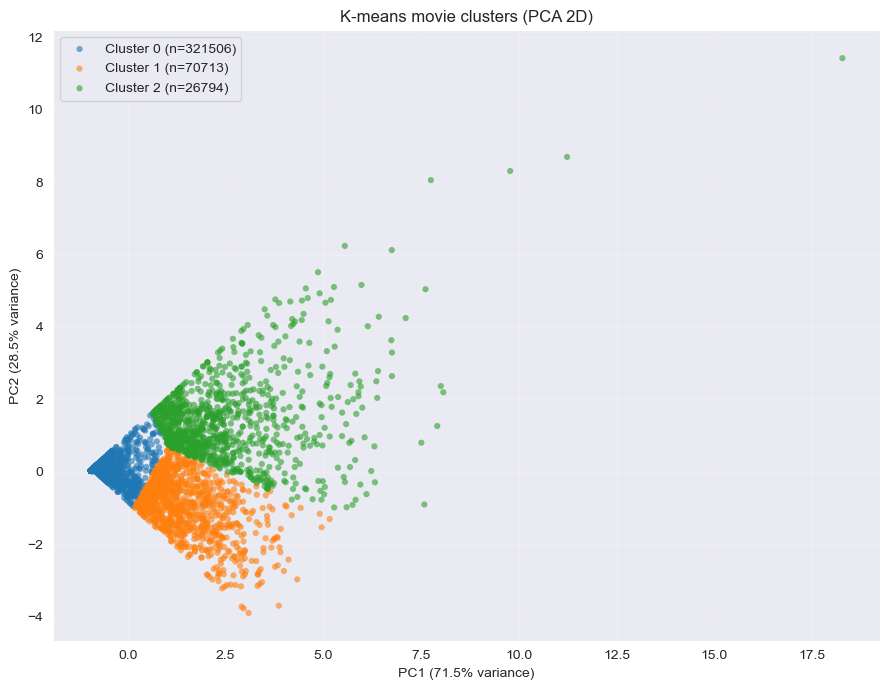

In [130]:
sync_dataframe(merged_data)
data = merged_data.copy()

data = users_for_clustering[user_features].astype(float)
data = data[user_features].dropna()

scalar = StandardScaler()
scaled_data = scalar.fit_transform(data)

print(elbow_method(data))

# k-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(scaled_data)

users_for_clustering["cluster_id"] = cluster_labels
print(users_for_clustering["cluster_id"].value_counts().sort_index())
print(compute_silhouette_score(scaled_data, cluster_labels, 20000))

plot_clusters_pca_2d(scaled_data, cluster_labels)

#add_new_df("user_clusters", "user_clusters", users_for_clustering)